# Investigating the bioremediation potential of seaweed aquaculture

across Australia

In [ ]:
# You need quarto to generate this markdown - install here: https://quarto.org/docs/get-started/
# This markdown uses the acronyms extension - install by entering quarto add rchaput/acronyms@master into the terminal
# This markdown uses TinyTex for PDF rendering - install with tinytex::install_tinytex()

library(stringr)
library(units)

udunits database from C:/Users/treimer/AppData/Local/R/cache/R/renv/cache/v5/windows/R-4.4/x86_64-w64-mingw32/units/0.8-7/5d0b024902d5da97a2b64f002e92a869/units/share/udunits/udunits2.xml


Attaching package: 'arrow'

The following object is masked from 'package:utils':

    timestamp

Loading required package: ggplot2


Attaching package: 'magrittr'

The following object is masked from 'package:arrow':

    is_in


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

terra 1.8.42


Attaching package: 'terra'

The following objects are masked from 'package:magrittr':

    extract, inset

The following object is masked from 'package:gganimate':

    animate

The following object is masked from 'package:arrow':

    buffer


Attaching package: 'tidyterra'

The following object is masked from 'package:stats':

    filter

here() starts at C:/Users/treimer/Documents/R-temp-files/modelling-asparagopsis


Attaching package: 'lubridate'

The following objects are masked from 'package:terra':

    intersect, union

The following object is masked from 'package:arrow':

    duration

The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Attaching package: 'tidyr'

The following object is masked from 'package:terra':

    extract

The following object is masked from 'package:magrittr':

    extract

[conflicted] Will prefer dplyr::select over any other package.

[conflicted] Will prefer dplyr::filter over any other package.

In [ ]:
# source(file.path(base_path, "R", "other-functions.R"))
spec_store <- here() %>% file.path("targets_outputs", "_species")
cell_store <- here() %>% file.path("targets_outputs", "_model_running_TAS")
spec_data <- here() %>% file.path("data", "processed_species")
cell_data <- here() %>% file.path("data", "processed_cell_data")
runs_data <- here() %>% file.path("data", "processed_model_running")

bounds <- tar_read(states_bbox, store = cell_store)

prettyplot <- theme_classic() +
  theme(text = element_text(family = "sans", size = 12, colour = "black"),
        axis.title = element_text(vjust = 2),
        legend.position = "none")

env_plot <- prettyplot +
  theme(legend.position = "none",
        aspect.ratio = 0.55,
        text = element_text(family = "sans", size = 11, colour = "black"))

nitrogen_lab <- expression("Concentration ("*mu*"M N)")
nitrate_lab <- expression("Nitrate concentration ("*mu*"M NO"[3]*")")
ammonium_lab <- expression("Ammonium concentration ("*mu*"M NH"[4]^+")")

# Allows using "units" package to convert between moles and g of nitrogen ONLY
remove_unit("mol")
install_unit("mol", "14.0067 g")

prettynum <- function(num, sigfig=2) {format(round(as.numeric(num), sigfig), nsmall=1, big.mark=",")}

species_pal <- c("red3", "dodgerblue3")
depths_pal <- c("green3", "#FF8247", "dodgerblue3", "#292928")
states_pal <- c("#d95f02", "#e6ab02", "#7570b3", "#1b9e77", "#66a61e", "#e7298a", "#a6761d", "#666666")
scens_pal_1 <- c("#292928", "dodgerblue3", "#66a61e", "#e7298a", "#e6ab02")
scens_pal_2 <- c("dodgerblue3", "#66a61e", "#e7298a", "#e6ab02")
states_pal_2 <- c(states_pal, "black")
states <- tar_read(states, store = cell_store)
states_ord <- c("NTE", "QLD", "NSW", "SAU", "TAS", "VIC", "WAN", "WAS")
states_lng <- c("Northern Territory", "Queensland", "New South Wales", "South Australia", "Tasmania", "Victoria", "Western Australia (N)", "Western Australia (S)")

# Methods

In [ ]:
cell_coords <- tar_read(BARRA_C2_cell_coords, store = cell_store) %>% 
  mutate(state = factor(state, levels = states_ord)) %>% 
  dplyr::select(-layer)

totals <- cell_coords %>% 
  group_by(state) %>% 
  reframe(cells = n())

There were a total of 95418 cells used in this analysis: 5045 in Victoria, 5480 in New South Wales, 21956 in Queensland, 11451 in South Australia, 29062 in Western Australia (divided into 13794 cells in the north and 15268 in the south), 10185 in Tasmania, and 12239 in the Northern Territory.

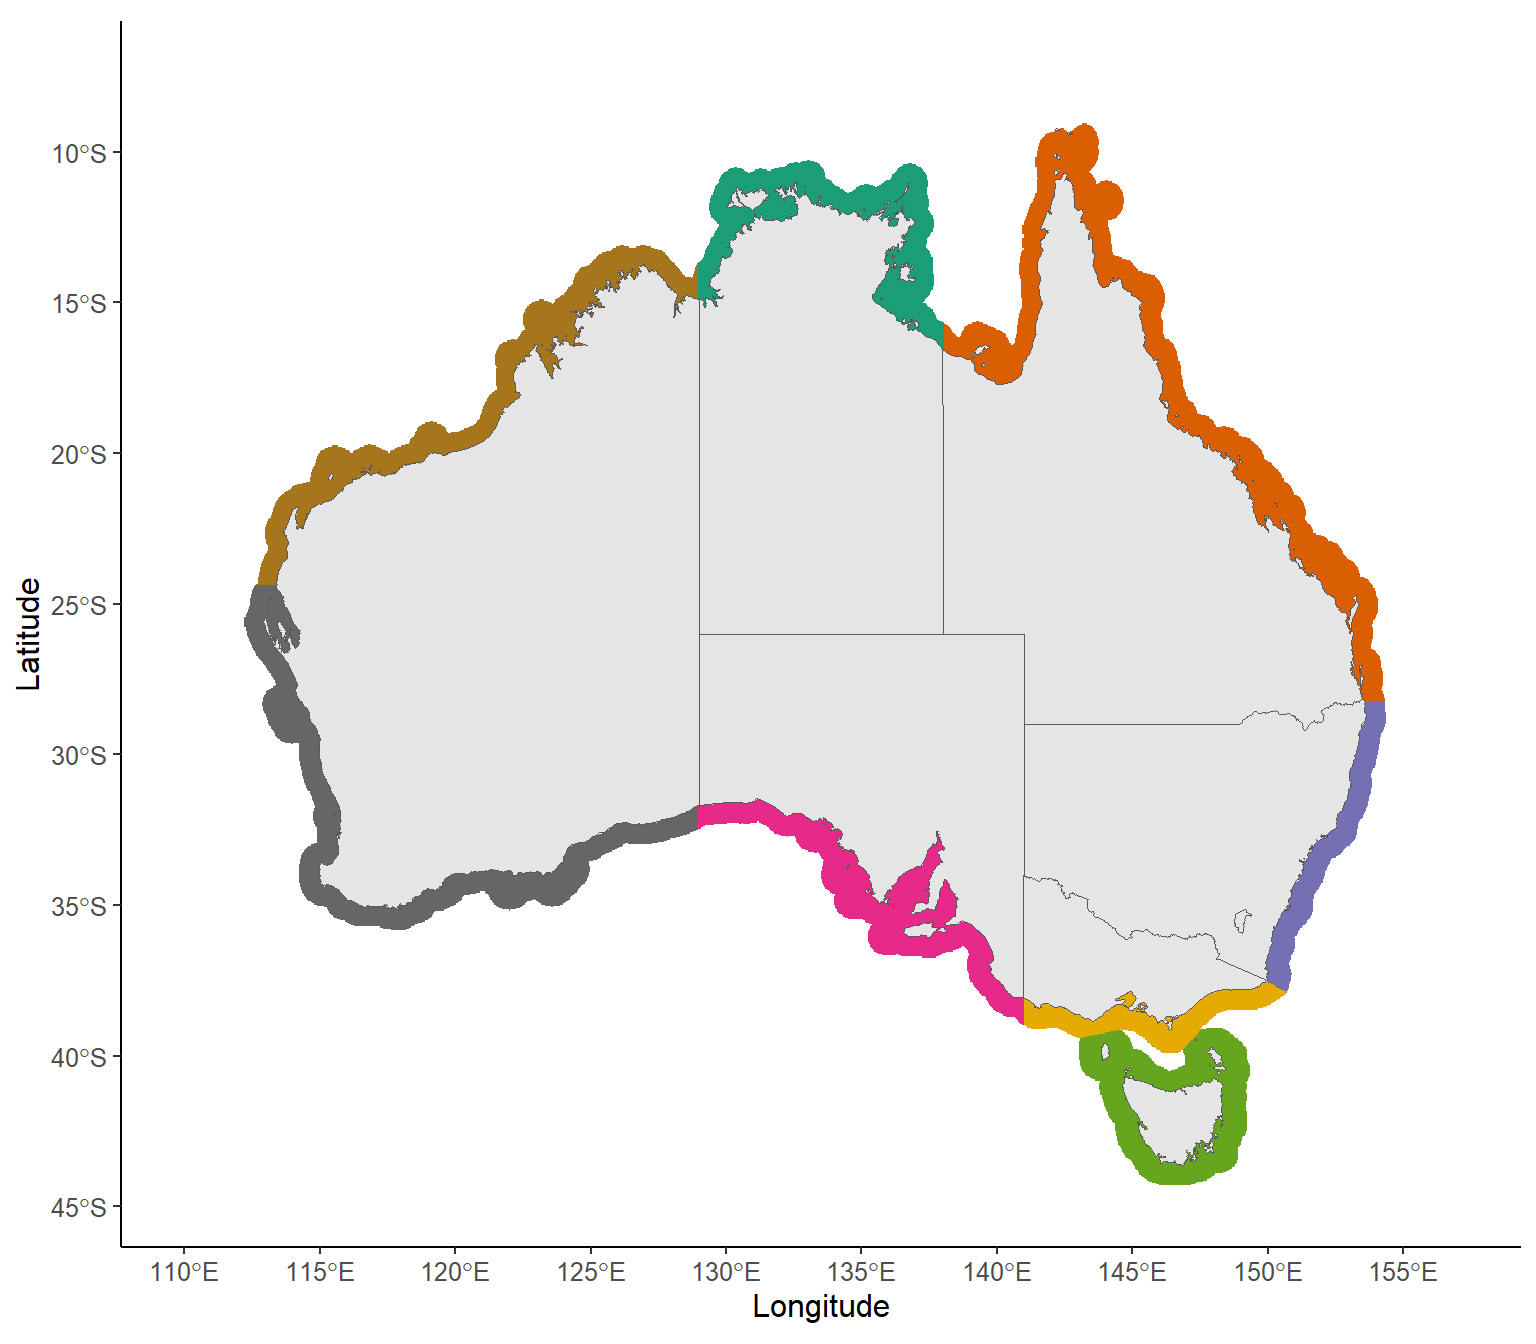

In [ ]:
ggplot(cell_coords, aes(x = longitude, y = latitude, fill = state)) +
  geom_raster() +
  geom_sf(data = ozmap_data(data = "states"), inherit.aes = F) +
  coord_sf(xlim = c(bounds[["AUS"]]["lonmin"], bounds[["AUS"]]["lonmax"]),
           ylim = c(bounds[["AUS"]]["latmin"], bounds[["AUS"]]["latmax"])) +
  scale_x_continuous(breaks = seq(100, 160, 5)) +
  scale_y_continuous(breaks = seq(-5, -45, -5)) +
  scale_color_brewer(palette = "Dark2") +
  scale_fill_brewer(palette = "Dark2") +
  labs(x = "Longitude", y = "Latitude") +
  prettyplot +
  theme(legend.position = "none")

## Environmental inputs

In [ ]:
cell_input_timeseries <- list(
  here() %>% file.path("data", "processed_cell_data", "cell_input_timeseries_TAS.parquet") %>% read_parquet(),
  here() %>% file.path("data", "processed_cell_data", "cell_input_timeseries_VIC.parquet") %>% read_parquet(),
  here() %>% file.path("data", "processed_cell_data", "cell_input_timeseries_NTE.parquet") %>% read_parquet(),
  here() %>% file.path("data", "processed_cell_data", "cell_input_timeseries_QLD.parquet") %>% read_parquet(),
  here() %>% file.path("data", "processed_cell_data", "cell_input_timeseries_SAU.parquet") %>% read_parquet(),
  here() %>% file.path("data", "processed_cell_data", "cell_input_timeseries_WAN.parquet") %>% read_parquet(),
  here() %>% file.path("data", "processed_cell_data", "cell_input_timeseries_WAS.parquet") %>% read_parquet(),
  here() %>% file.path("data", "processed_cell_data", "cell_input_timeseries_NSW.parquet") %>% read_parquet()
  ) %>% 
  bind_rows() %>% 
  mutate(state = factor(state, levels = states_ord, labels = states_lng))

In [ ]:
T_input <- cell_input_timeseries %>% 
  select(cell_no, state, yday, T_input)

(T_means <- T_input %>% 
  group_by(state) %>% 
  reframe(mean = mean(T_input, na.rm = T),
          max = max(T_input, na.rm = T),
          min = min(T_input, na.rm = T)) %>% 
  mutate(variable = "T_input"))

# A tibble: 8 × 5
  state                  mean   max   min variable
  <fct>                 <dbl> <dbl> <dbl> <chr>   
1 Northern Territory     28.5  37.9 18.9  T_input 
2 Queensland             26.5  36.1 12.6  T_input 
3 New South Wales        21.6  30.8  7.77 T_input 
4 South Australia        17.1  31.8  7.12 T_input 
5 Tasmania               15.0  24.3  3.95 T_input 
6 Victoria               15.9  29.7  6.48 T_input 
7 Western Australia (N)  27.5  40.9 17.3  T_input 
8 Western Australia (S)  20.2  38.7  9.02 T_input 

Mean daily temperature ranged from 15 in Tasmania to 28.5 in Northern Territory, with a mean across states of 21.5.

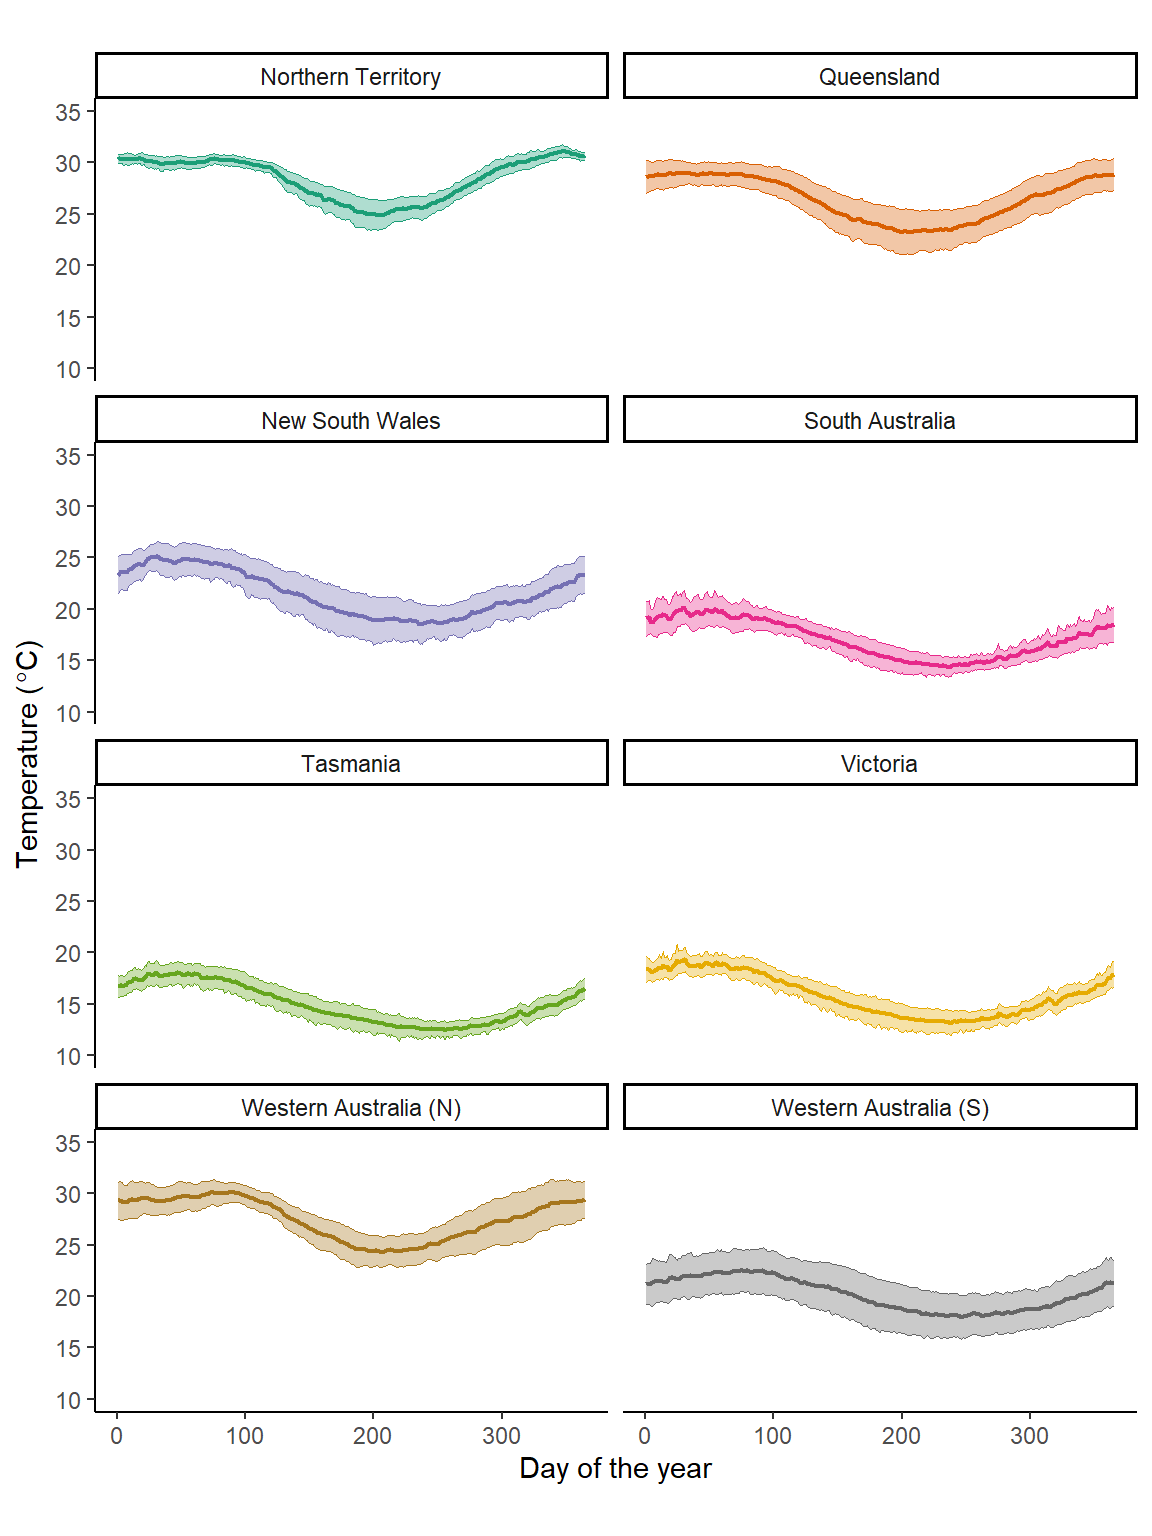

In [ ]:
T_input_state <- T_input %>%
  group_by(state, yday) %>% 
  reframe(value = mean(T_input, na.rm = T),
          sd = sd(T_input, na.rm = T))

(
  p_input_state_av <- T_input_state %>% 
    ggplot(aes(x = yday, y = value, ymin = value-sd, ymax = value+sd, colour = state, fill = state)) +
    geom_line(linewidth = 0.75) +
    geom_ribbon(alpha = 0.35, linewidth = 0.25) +
    facet_wrap(facets = vars(state), ncol = 2) +
    scale_y_continuous(breaks = seq(0, 40, 5), limits = c(10, 35)) +
    scale_fill_brewer(palette = "Dark2") +
    scale_color_brewer(palette = "Dark2") +
    env_plot +
    labs(x = "Day of the year", y = expression("Temperature ("*degree*"C)"))
)

In [ ]:
I_input <- cell_input_timeseries %>% 
  select(cell_no, state, yday, I_input)

(I_means <- I_input %>% 
  group_by(state) %>% 
  reframe(mean = mean(I_input, na.rm = T),
          max = max(I_input, na.rm = T),
          min = min(I_input, na.rm = T)) %>% 
  mutate(variable = "I_input"))

# A tibble: 8 × 5
  state                  mean   max   min variable
  <fct>                 <dbl> <dbl> <dbl> <chr>   
1 Northern Territory     372.  639.  5.04 I_input 
2 Queensland             314.  655. 14.1  I_input 
3 New South Wales        269.  650. 14.1  I_input 
4 South Australia        267.  734.  6.70 I_input 
5 Tasmania               193.  696.  2.98 I_input 
6 Victoria               218.  678.  5.78 I_input 
7 Western Australia (N)  449.  705. 31.8  I_input 
8 Western Australia (S)  303.  736.  8.17 I_input 

Mean daily irradiance ranged from 193 in Tasmania to 449 in Western Australia (N), with a mean across states of 298.

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.

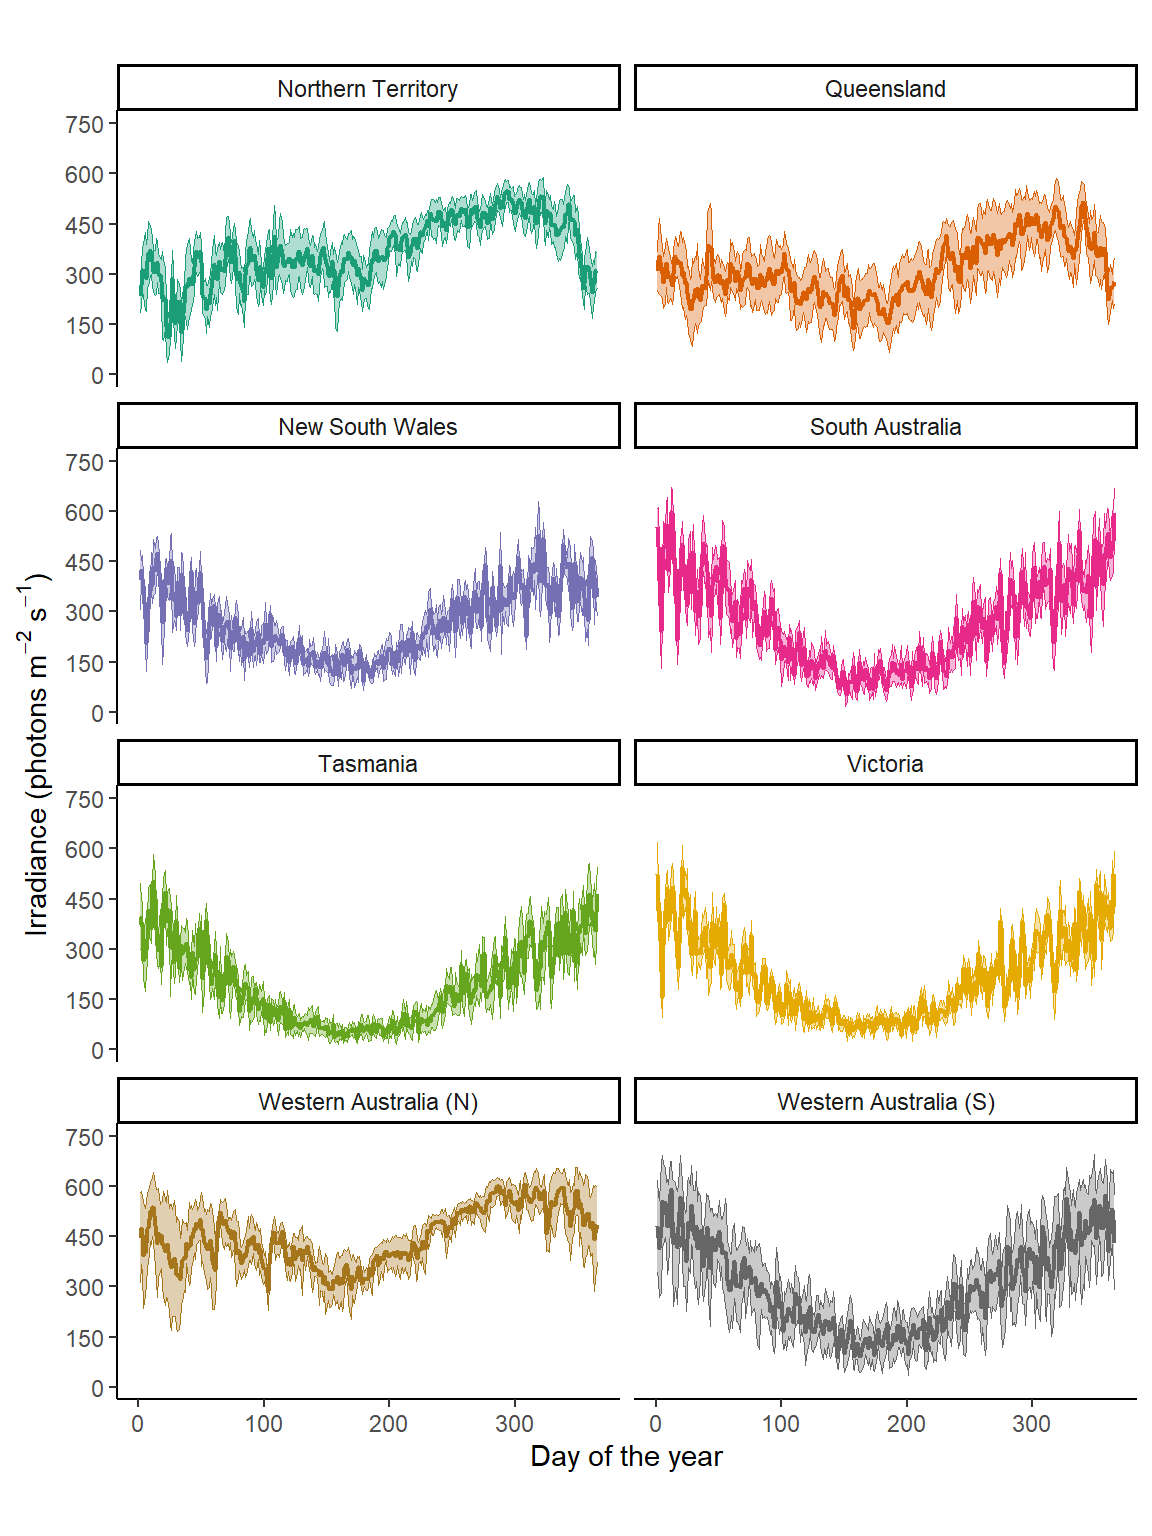

In [ ]:
I_input_state <- I_input %>%
  group_by(state, yday) %>% 
  reframe(value = mean(I_input, na.rm = T),
          sd = sd(I_input, na.rm = T))

p_input_state_av %+% I_input_state +
  scale_y_continuous(breaks = seq(0, 1600, 150), limits = c(0, 750)) +
  labs(x = "Day of the year", y = expression("Irradiance (photons m"^-2*" s"^-1*")")) 

In [ ]:
S_input <- cell_input_timeseries %>% 
  select(cell_no, state, yday, S_input)

(S_means <- S_input %>% 
  group_by(state) %>% 
  reframe(mean = mean(S_input, na.rm = T),
          max = max(S_input, na.rm = T),
          min = min(S_input, na.rm = T)) %>% 
  mutate(variable = "S_input"))

# A tibble: 8 × 5
  state                  mean   max   min variable
  <fct>                 <dbl> <dbl> <dbl> <chr>   
1 Northern Territory     34.5  35.6  32.8 S_input 
2 Queensland             35.0  35.9  32.9 S_input 
3 New South Wales        35.5  35.7  35.1 S_input 
4 South Australia        35.9  37.2  35.2 S_input 
5 Tasmania               35.4  35.7  34.9 S_input 
6 Victoria               35.5  35.8  35.3 S_input 
7 Western Australia (N)  34.9  35.9  34.2 S_input 
8 Western Australia (S)  35.7  36.4  35.0 S_input 

Mean daily salinity ranged from 34.5 in Northern Territory to 35.9 in South Australia, with a mean across states of 35.3.

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.

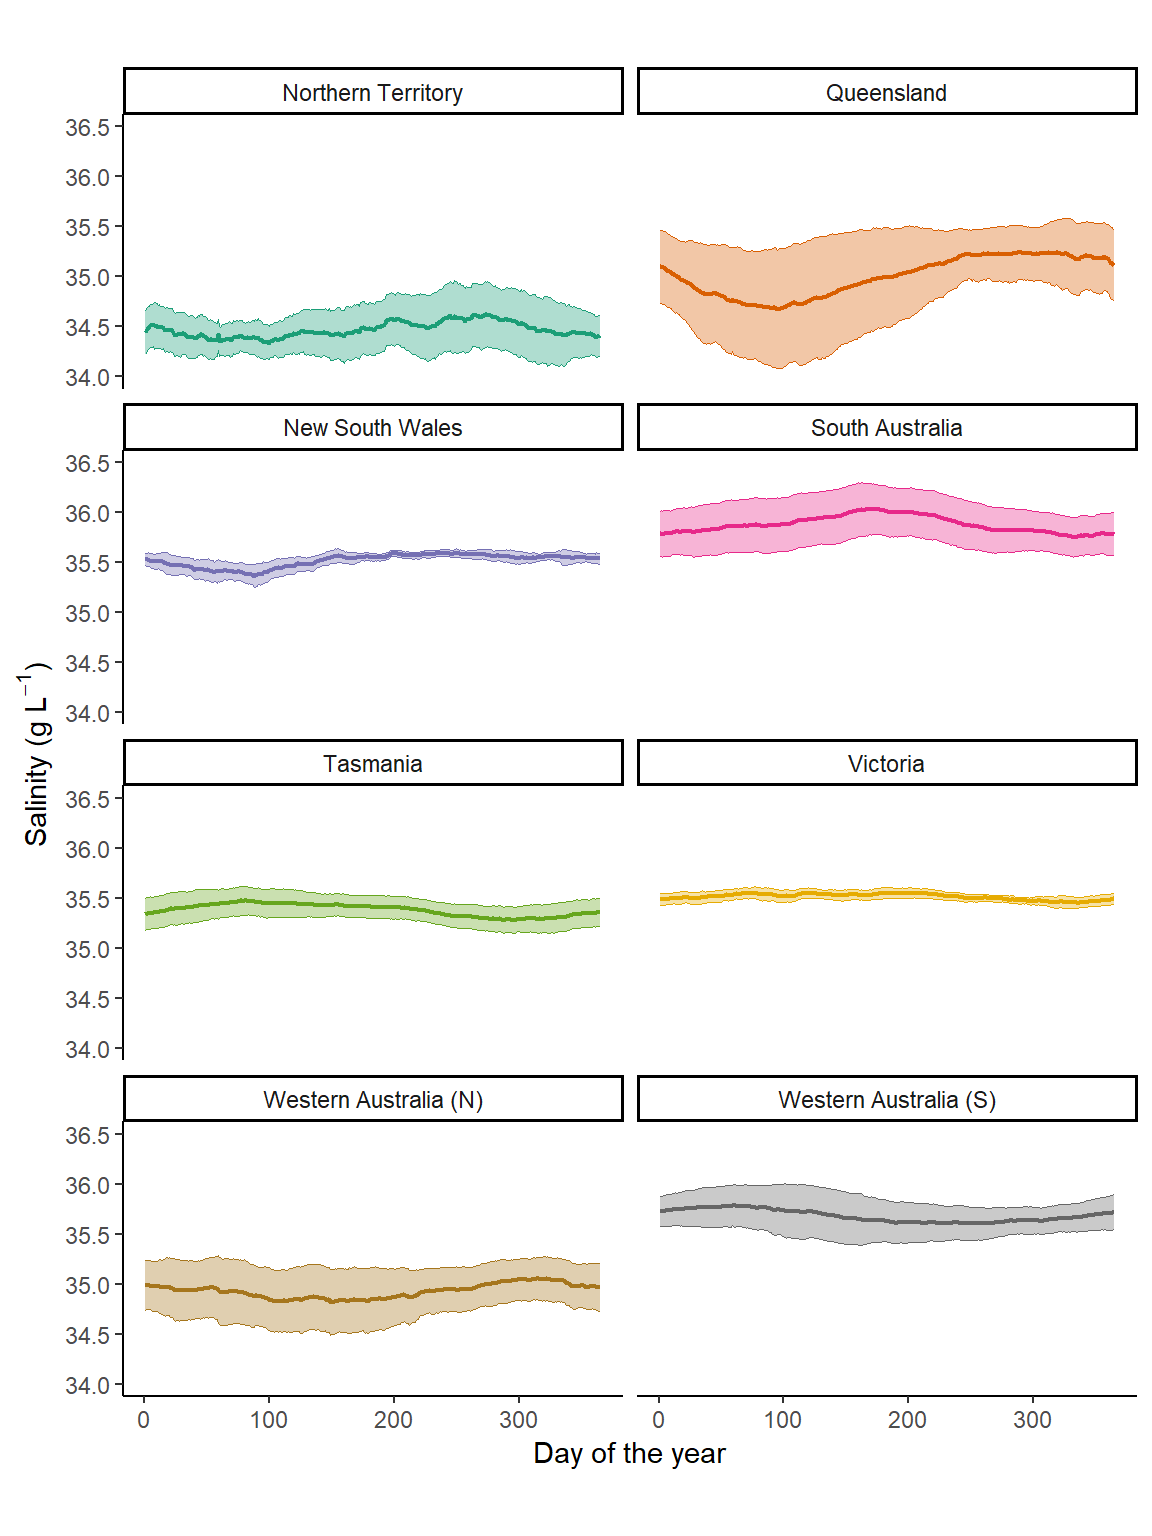

In [ ]:
S_input_state <- S_input %>%
  group_by(state, yday) %>% 
  reframe(value = mean(S_input, na.rm = T),
          sd = sd(S_input, na.rm = T))

p_input_state_av %+% S_input_state +
  scale_y_continuous(breaks = seq(30, 40, 0.5), limits = c(34, 36.5)) +
  labs(x = "Day of the year", y = expression("Salinity (g L"^-1*")"))

In [ ]:
UV_input <- cell_input_timeseries %>% 
  select(cell_no, state, yday, UV_input)

(UV_means <- UV_input %>% 
  group_by(state) %>% 
  reframe(mean = mean(UV_input, na.rm = T),
          max = max(UV_input, na.rm = T),
          min = min(UV_input, na.rm = T)) %>% 
  mutate(variable = "UV_input"))

# A tibble: 8 × 5
  state                   mean   max       min variable
  <fct>                  <dbl> <dbl>     <dbl> <chr>   
1 Northern Territory    0.0641 0.348 0.0000366 UV_input
2 Queensland            0.145  1.06  0.0000336 UV_input
3 New South Wales       0.357  1.46  0.000455  UV_input
4 South Australia       0.0798 0.689 0.0000366 UV_input
5 Tasmania              0.0871 0.622 0.0000262 UV_input
6 Victoria              0.0971 0.785 0.000114  UV_input
7 Western Australia (N) 0.0687 0.559 0.0000110 UV_input
8 Western Australia (S) 0.139  0.843 0.0000548 UV_input

Mean daily water velocity ranged from 0.06 in Northern Territory to 0.36 in New South Wales, with a mean across states of 0.13.

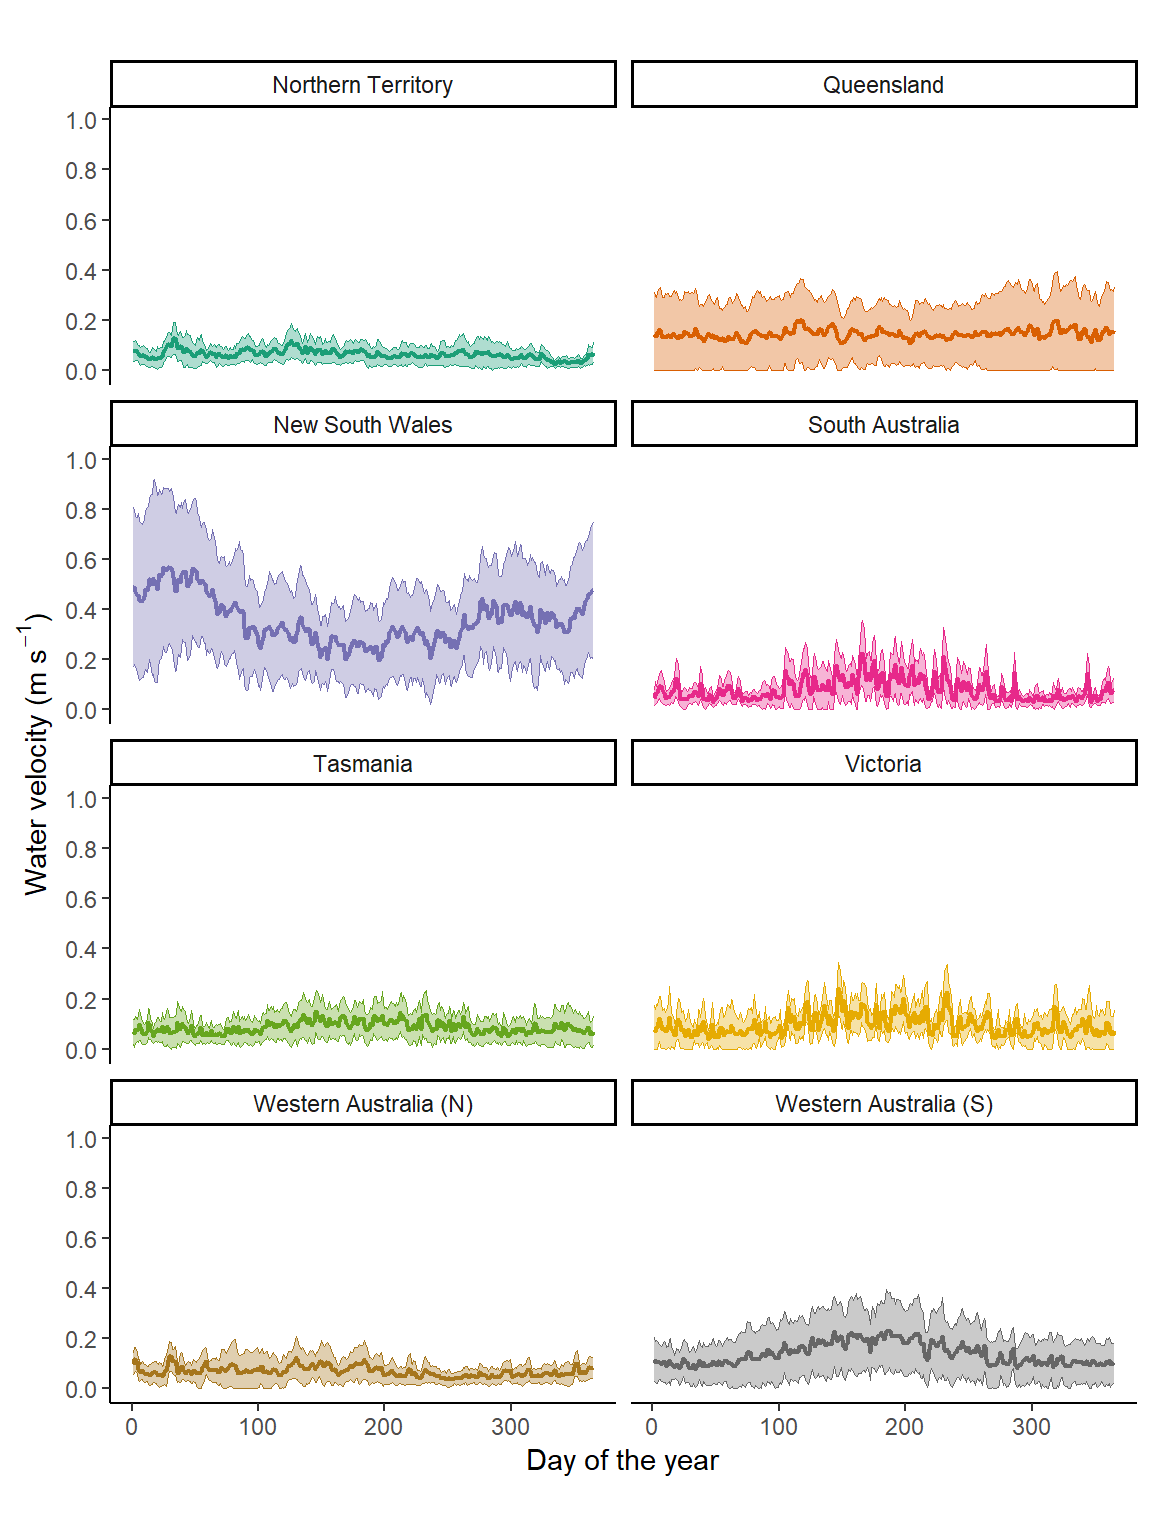

In [ ]:
UV_input_state <- UV_input %>%
  group_by(state, yday) %>% 
  reframe(value = mean(UV_input, na.rm = T),
          sd = sd(UV_input, na.rm = T)) %>% 
  mutate(sd_min = case_when(sd > value ~ value, T ~ sd))

(
  p_input_state_av <- UV_input_state %>% 
    ggplot(aes(x = yday, y = value, ymin = value-sd_min, ymax = value+sd, colour = state, fill = state)) +
    geom_line(linewidth = 0.75) +
    geom_ribbon(alpha = 0.35, linewidth = 0.25) +
    facet_wrap(facets = vars(state), ncol = 2) +
    scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(-0.01, 1)) +
    scale_fill_brewer(palette = "Dark2") +
    scale_color_brewer(palette = "Dark2") +
    env_plot +
    labs(x = "Day of the year", y = expression("Water velocity (m s"^-1*")"))
)

## Nitrogen

In [ ]:
refstation_locations <- here() %>% 
  file.path("data", "nitrogen", "refstation_locations.parquet") %>% 
  arrow::read_parquet() %>% 
  mutate(state = case_when(
    lon > bounds[["SAU"]]["lonmin"] & lon <= bounds[["SAU"]]["lonmax"] & 
      lat > bounds[["SAU"]]["latmin"] & lat <= bounds[["SAU"]]["latmax"]  ~ "SAU",
    lon > bounds[["QLD"]]["lonmin"] & lon <= bounds[["QLD"]]["lonmax"] & 
      lat > bounds[["QLD"]]["latmin"] & lat <= bounds[["QLD"]]["latmax"]  ~ "QLD",
    lon > bounds[["WAS"]]["lonmin"] & lon <= bounds[["WAS"]]["lonmax"] & 
      lat > bounds[["WAS"]]["latmin"] & lat <= bounds[["WAS"]]["latmax"]  ~ "WAS",
    lon > bounds[["WAN"]]["lonmin"] & lon <= bounds[["WAN"]]["lonmax"] & 
      lat > bounds[["WAN"]]["latmin"] & lat <= bounds[["WAN"]]["latmax"]  ~ "WAN",
    lon > bounds[["VIC"]]["lonmin"] & lon <= bounds[["VIC"]]["lonmax"] & 
      lat > bounds[["VIC"]]["latmin"] & lat <= bounds[["VIC"]]["latmax"]  ~ "VIC",
    lon > bounds[["NSW"]]["lonmin"] & lon <= bounds[["NSW"]]["lonmax"] & 
      lat > bounds[["NSW"]]["latmin"] & lat <= bounds[["NSW"]]["latmax"]  ~ "NSW",
    lon > bounds[["NTE"]]["lonmin"] & lon <= bounds[["NTE"]]["lonmax"] & 
      lat > bounds[["NTE"]]["latmin"] & lat <= bounds[["NTE"]]["latmax"]  ~ "NTE",
    lon > bounds[["TAS"]]["lonmin"] & lon <= bounds[["TAS"]]["lonmax"] & 
      lat > bounds[["TAS"]]["latmin"] & lat <= bounds[["TAS"]]["latmax"]  ~ "TAS",
    TRUE ~ NA
  ),
  state = factor(state, levels = states_ord)) %>% 
  rename(latitude = lat, longitude = lon, name = StationName) %>% 
  dplyr::select(-code) %>% 
  relocate(state, .before = name)

outfall_locations <- here() %>% 
  file.path("data_raw", "national-outfall-database", "data-output", "outflow_site_locations.parquet") %>% 
  arrow::read_parquet() %>% 
  mutate(state = factor(state, levels = states_ord)) %>% 
  relocate(state, .before = name)

N_locations <- rbind(
  outfall_locations %>% mutate(type = "outfall"),
  refstation_locations %>% mutate(type = "refstation")
)

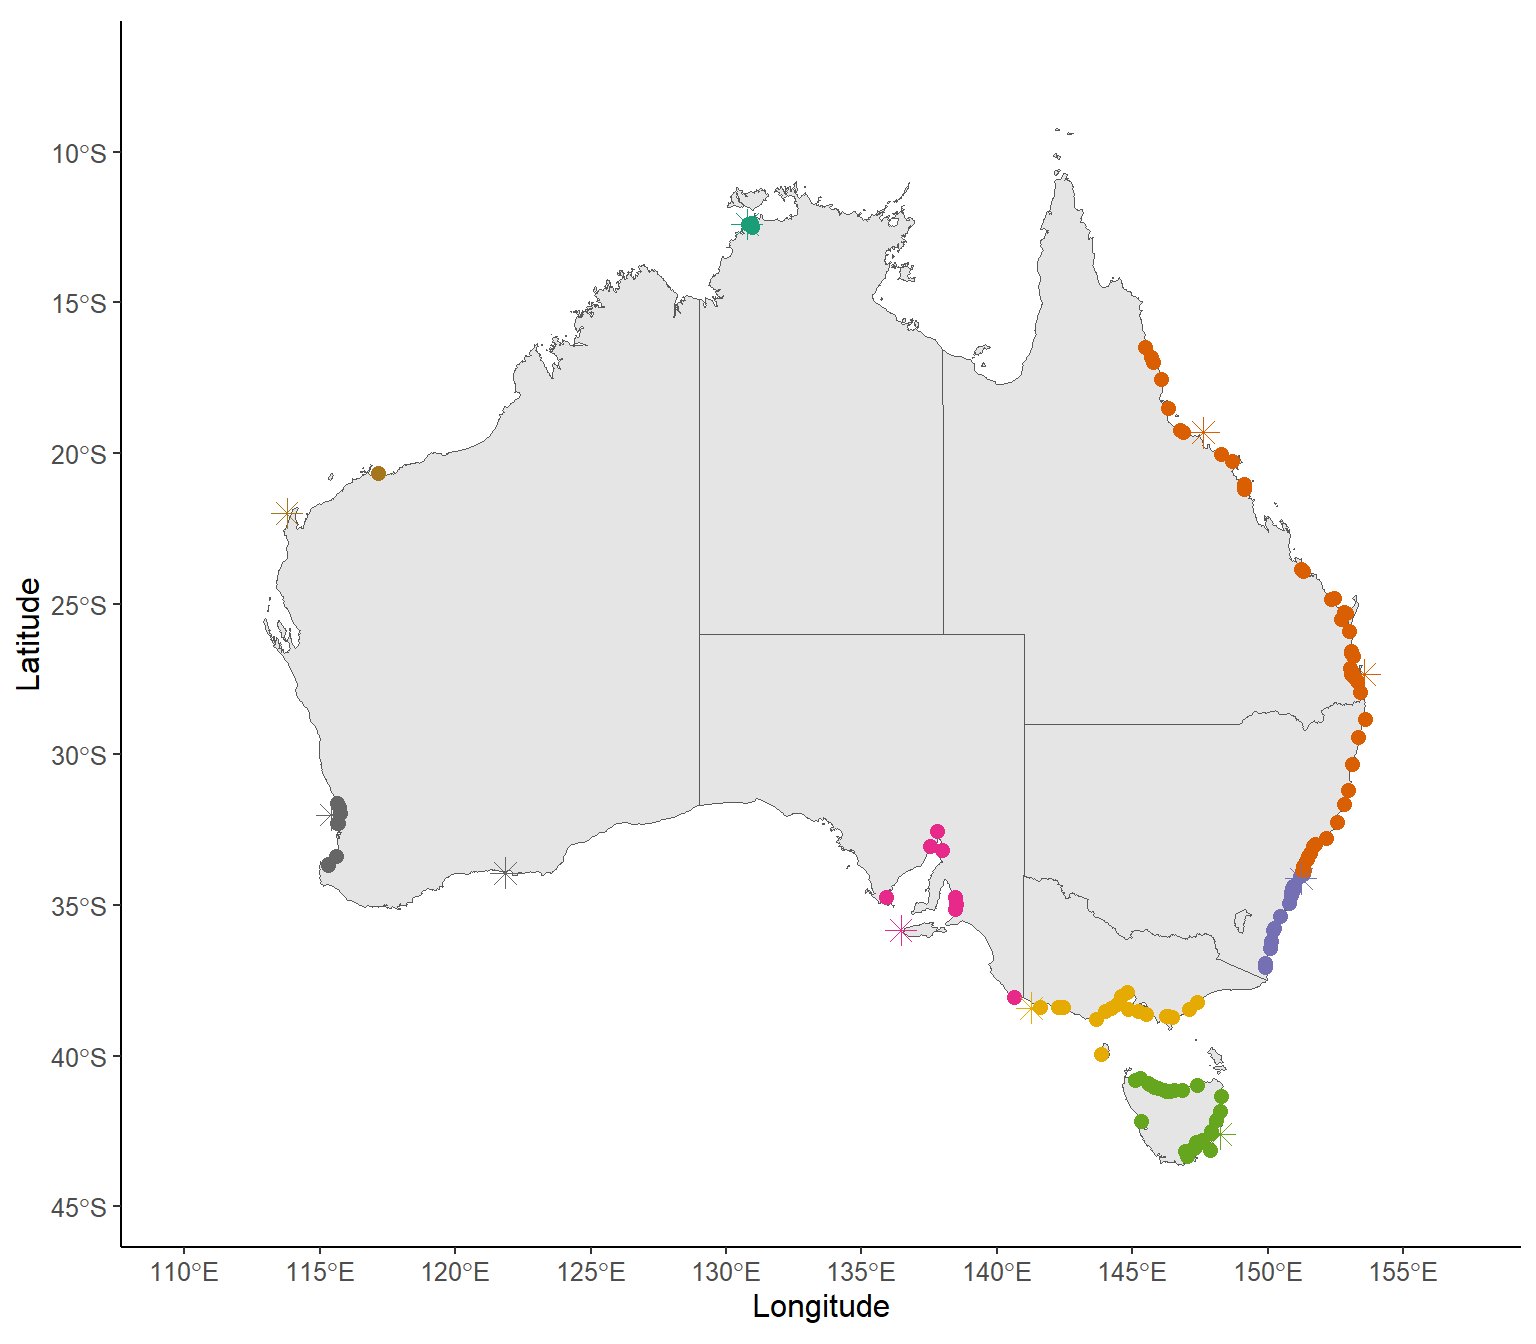

In [ ]:
ggplot(N_locations, aes(x = longitude, y = latitude, color = state, shape = type)) +
  geom_sf(data = ozmap_data(data = "states"), inherit.aes = F) +
  coord_sf(xlim = c(bounds[["AUS"]]["lonmin"], bounds[["AUS"]]["lonmax"]),
           ylim = c(bounds[["AUS"]]["latmin"], bounds[["AUS"]]["latmax"])) +
  geom_point(size = 3.5) +
  scale_shape_manual(values = c(20, 8)) +
  # scale_colour_manual(values = states_pal, labels = states_lng, na.value = "black") +
  scale_color_brewer(palette = "Dark2") +
  scale_x_continuous(breaks = seq(100, 160, 5)) +
  scale_y_continuous(breaks = seq(-5, -45, -5)) +
  labs(x = "Longitude", y = "Latitude") +
  prettyplot +
  theme(legend.position = "none")

In [ ]:
refstation_cell_match <- list(
  file.path(cell_data, "refstation_cell_match_NTE.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "refstation_cell_match_TAS.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "refstation_cell_match_VIC.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "refstation_cell_match_QLD.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "refstation_cell_match_SAU.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "refstation_cell_match_WAN.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "refstation_cell_match_WAS.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "refstation_cell_match_NSW.parquet") %>% arrow::read_parquet()
  ) %>% 
  bind_rows() %>% 
  group_by(StationName) %>% 
  reframe(num_cells = n())

Matching model cells to their two nearest reference stations resulted in 40.77% cells using data from Darwin, 31.01% from Kangaroo Island, 24.72% from Maria Island, 15.84% from North Stradbroke Island, 20.6% from Port Hacking, 31.04% from Rottnest Island, and 36.03% from Yongala.

In [ ]:
outfall_sites_cellpaired <- list(
  file.path(cell_data, "outfall_sites_cellpaired_NTE.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "outfall_sites_cellpaired_TAS.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "outfall_sites_cellpaired_VIC.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "outfall_sites_cellpaired_QLD.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "outfall_sites_cellpaired_SAU.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "outfall_sites_cellpaired_WAN.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "outfall_sites_cellpaired_WAS.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "outfall_sites_cellpaired_NSW.parquet") %>% arrow::read_parquet()
  ) %>% 
  bind_rows() %>% 
  group_by(state, cell_no) %>% 
  reframe(matched = n())

There were 8 outfall stations in South Australia, 9 in southern Western Australia, 4 in the Northern Territory, and 1 in northern Western Australia.

Matching cells to outfall stations within 48 km resulted in 93.56% of cells using data from one outfall site, 2.93% of cells using data from two sites, 2.13% of cells using data from three sites, 0.72% of cells using data from four sites, 0.29% of cells using data from five sites, and 0.3% of cells using data from six sites. The remaining 0% of cells did not use data from any outfall sites.

(`geom_point()`).

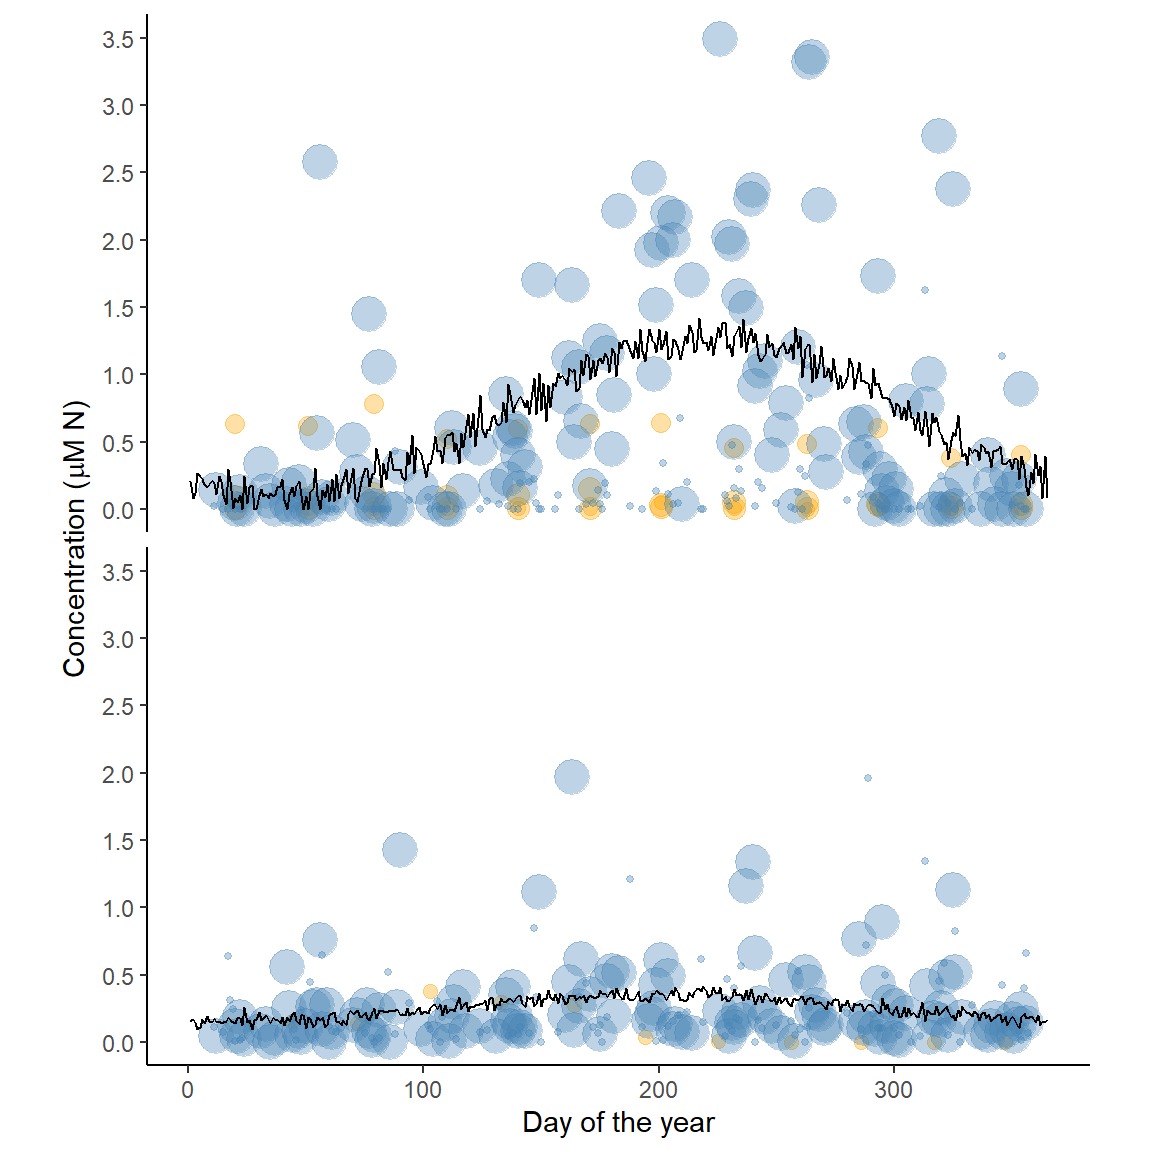

In [ ]:
st <- here() %>% file.path("targets_outputs", "_model_running_NSW")
BARRA_C2_cell_nos <- tar_read(BARRA_C2_cell_nos, store = st)
ind <- which(BARRA_C2_cell_nos == 753076)

ref <- tar_read(refstation_cell_match, branches = ind, store = st)
out <- tar_read(outfall_sites_cellpaired, branches = ind, store = st)

Ni_data_prioritised <- tar_read(Ni_data_prioritised, store = st, branches = ind)[[1]]["data"][[1]] %>% 
  mutate(form = "nitrate")
Am_data_prioritised <- tar_read(Am_data_prioritised, store = st, branches = ind)[[1]]["data"][[1]] %>% 
  mutate(form = "ammonium")
cell_input <- tar_read(cell_input_timeseries, store = st, branches = ind) %>% 
  dplyr::select(c(yday, Ni_input, Am_input, cell_no)) %>% 
  pivot_longer(names_to = "form", values_to = "value", cols = c(Ni_input, Am_input)) %>% 
  mutate(form = factor(form, levels = c("Ni_input", "Am_input"), labels = c("nitrate", "ammonium")),
         value = set_units(value, "mg m-3"),
         value = set_units(value, "umol L-1"),
         value = drop_units(value)) %>% 
  dplyr::filter(yday <= 365)

df <- rbind(
  Ni_data_prioritised, 
  Am_data_prioritised
) %>%
  mutate(value = set_units(value, "mg m-3"),
         value = set_units(value, "umol L-1"),
         value = drop_units(value),
         form = factor(form, levels = c("nitrate", "ammonium"))) %>% 
  filter(yday <= 365)
  
ggplot(df, aes(x = yday, y = value, fill = as.factor(data_source), colour = as.factor(data_source), size = weight)) +
  geom_point(shape = 21, alpha = 0.35) +
  facet_wrap(facets = vars(form), nrow = 2) +
  geom_line(data = cell_input, aes(x = yday, y = value), inherit.aes = F) +
  scale_fill_manual(values = c("orange", "steelblue")) +
  scale_colour_manual(values = c("orange", "steelblue")) +
  scale_y_continuous(limits = c(0, 3.5), breaks = seq(0, 4, 0.5)) +
  env_plot +
  theme(strip.text = element_blank()) +
  labs(x = "Day of the year", y = nitrogen_lab)

In [ ]:
Ni_input <- cell_input_timeseries %>% 
  select(cell_no, state, yday, Ni_input)

(Ni_means <- Ni_input %>% 
  group_by(state) %>% 
  reframe(mean = mean(Ni_input, na.rm = T),
          max = max(Ni_input, na.rm = T),
          min = min(Ni_input, na.rm = T)) %>% 
  mutate(variable = "Ni_input"))

# A tibble: 8 × 5
  state                  mean   max         min variable
  <fct>                 <dbl> <dbl>       <dbl> <chr>   
1 Northern Territory     3.70 17.9  0.255       Ni_input
2 Queensland             1.65 45.4  0.000000120 Ni_input
3 New South Wales        9.24 68.7  0           Ni_input
4 South Australia        6.32 46.9  0.0000149   Ni_input
5 Tasmania              21.0  45.7  1.77        Ni_input
6 Victoria              19.6  90.1  0.000140    Ni_input
7 Western Australia (N)  3.02  8.24 0.00000155  Ni_input
8 Western Australia (S)  1.79 11.2  0.142       Ni_input

Mean daily water velocity ranged from 1.65 in Queensland to 21.02 in Tasmania, with a mean across states of 8.29.

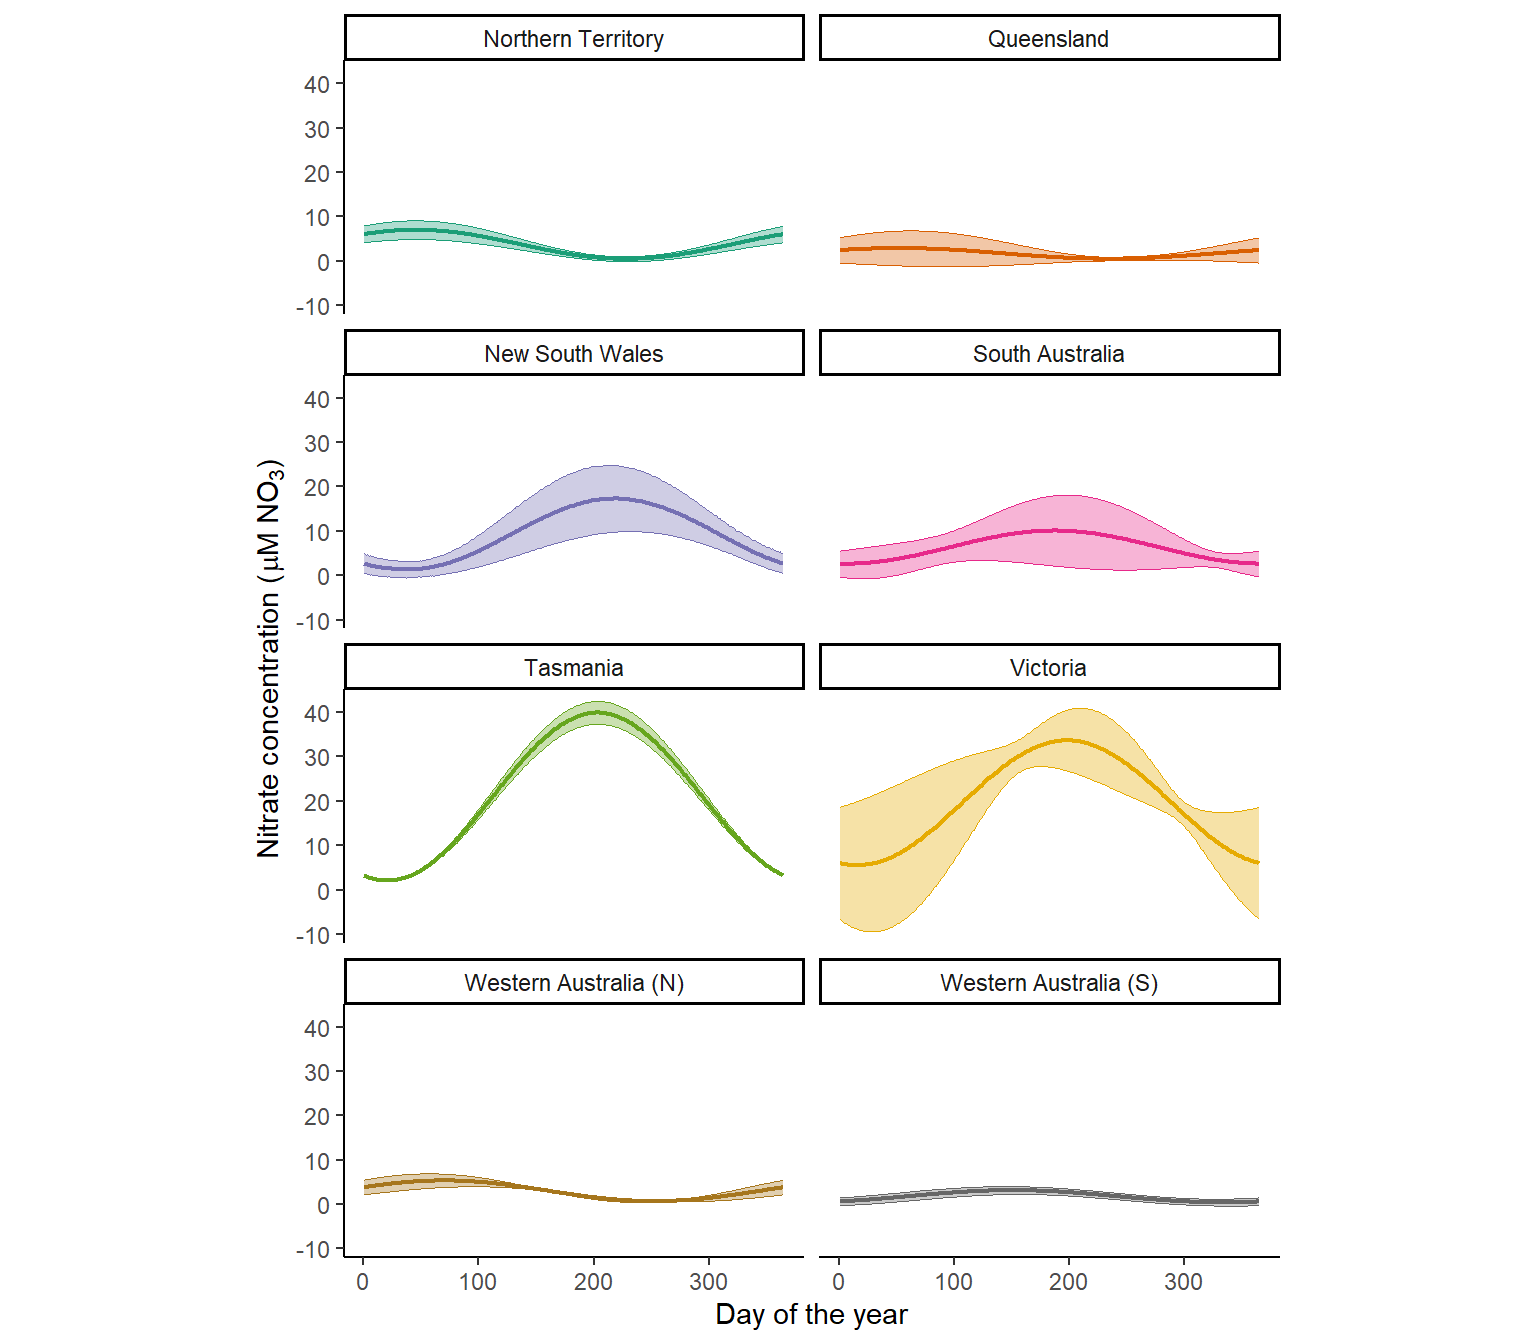

In [ ]:
Ni_input_state <- Ni_input %>%
  group_by(state, yday) %>% 
  reframe(value = mean(Ni_input, na.rm = T),
          sd = sd(Ni_input, na.rm = T))

(
  p_input_state_av <- Ni_input_state %>% 
    ggplot(aes(x = yday, y = value, ymin = value-sd, ymax = value+sd, colour = state, fill = state)) +
    geom_line(linewidth = 0.75) +
    geom_ribbon(alpha = 0.35, linewidth = 0.25) +
    facet_wrap(facets = vars(state), ncol = 2) +
    # scale_y_continuous(breaks = seq(0, 40, 5), limits = c(10, 35)) +
    scale_fill_brewer(palette = "Dark2") +
    scale_color_brewer(palette = "Dark2") +
    env_plot +
    labs(x = "Day of the year", y = nitrate_lab)
)

In [ ]:
Am_input <- cell_input_timeseries %>% 
  select(cell_no, state, yday, Am_input)

(Am_means <- Am_input %>% 
  group_by(state) %>% 
  reframe(mean = mean(Am_input, na.rm = T),
          max = max(Am_input, na.rm = T),
          min = min(Am_input, na.rm = T)) %>% 
  mutate(variable = "Am_input"))

# A tibble: 8 × 5
  state                  mean   max        min variable
  <fct>                 <dbl> <dbl>      <dbl> <chr>   
1 Northern Territory     2.36  4.65 1.21       Am_input
2 Queensland             1.63  6.45 0.0000244  Am_input
3 New South Wales        3.29  6.91 0.393      Am_input
4 South Australia        2.66  6.42 0.00000652 Am_input
5 Tasmania               2.11  9.06 0.00000695 Am_input
6 Victoria               2.76 50.4  0.00000877 Am_input
7 Western Australia (N)  1.94  3.79 0.0000357  Am_input
8 Western Australia (S)  1.34  2.40 0.367      Am_input

Mean daily water velocity ranged from 1.34 in Western Australia (S) to 3.29 in New South Wales, with a mean across states of 2.26.

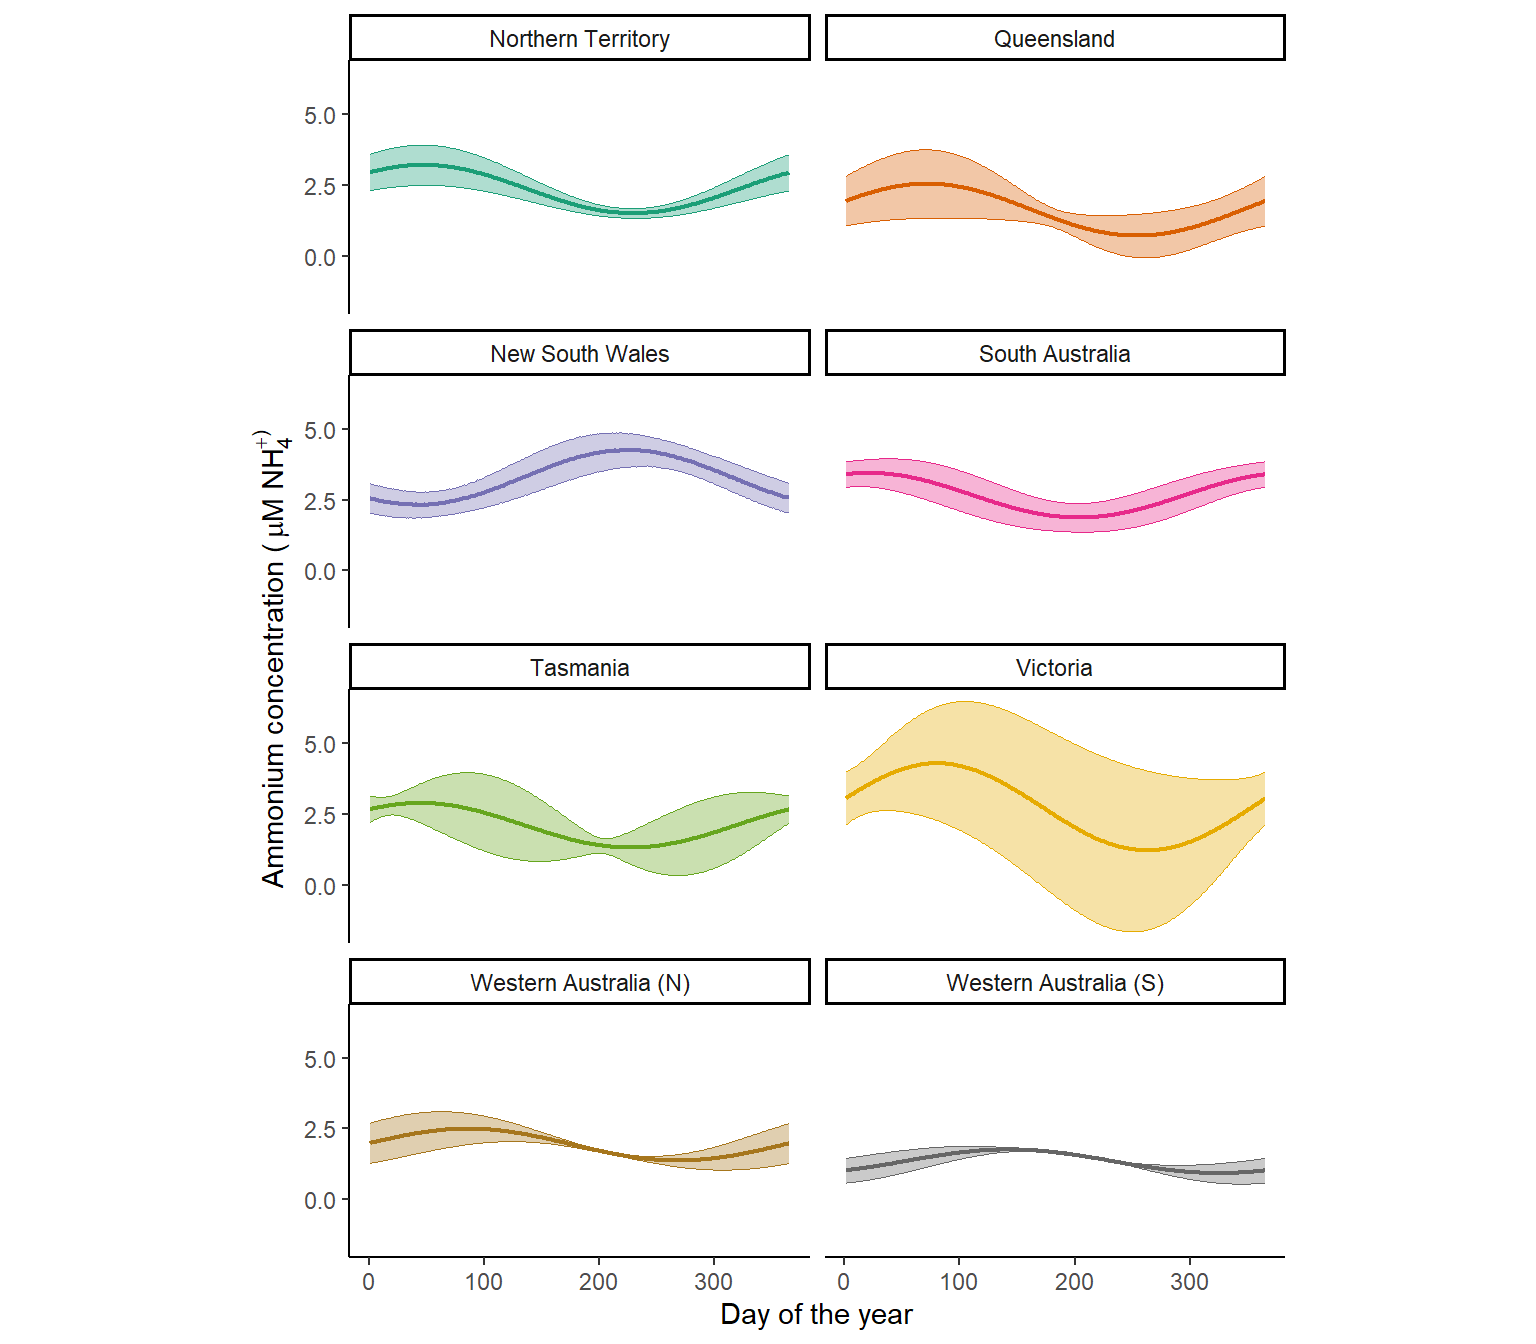

In [ ]:
Am_input_state <- Am_input %>%
  group_by(state, yday) %>% 
  reframe(value = mean(Am_input, na.rm = T),
          sd = sd(Am_input, na.rm = T))

p_input_state_av %+% Am_input_state +
  # scale_y_continuous(breaks = seq(30, 40, 0.5), limits = c(34, 36.5)) +
  labs(x = "Day of the year", y = ammonium_lab)

## Sensitivity conditions

In [ ]:
library(patchwork)

culture_depths <- tar_read(culture_depths, store = spec_store)
factors <- tar_read(factors, store = spec_store)

state_input_timeseries <- list(
  file.path(cell_data, "state_input_timeseries_NTE.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "state_input_timeseries_TAS.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "state_input_timeseries_VIC.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "state_input_timeseries_QLD.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "state_input_timeseries_SAU.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "state_input_timeseries_WAS.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "state_input_timeseries_WAN.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "state_input_timeseries_NSW.parquet") %>% arrow::read_parquet()
) %>% 
  bind_rows()

sens_cond <- file.path(spec_data, "sensitivity_conditions.parquet") %>% 
  arrow::read_parquet()

Culture depths tested were 0.5, 2.5, 5, 10 m below the surface, with a

Sensitivity runs started on the first of every month to cover annual variability, for 12 runs per year, with the same mean annual conditions looping from December to January. Sensitivity runs were conducted at culture depths of 0.5 m, 2 m, 3.5 m, and 5 m below the surface with a light attenuation coefficient of 0.65 (clear water). The canopy was always 2.5 m in height, and the total water column depth was always 50 m. Curves for temperature, surface irradiance, salinity, water velocity, nitrate and ammonium were constructed to capture “typical” conditions based on daily means of each state from 2019-2023. This resulted in two sensitivity curves for temperature (fig-state-temperature) and a single sensitivity curve for irradiance (fig-state-irradiance), water velocity (fig-state-water-velocity), salinity (fig-state-salinity), nitrate (fig-state-nitrate) and ammonium (fig-state-ammonium).

In [ ]:
p1 <- state_input_timeseries %>% 
  dplyr::select(state, yday, T_input_mean, T_input_sd) %>% 
  mutate(state = factor(state, levels = states_ord)) %>% 
  ggplot(aes(x = yday, y = T_input_mean, colour = state)) +
  geom_line(linewidth = 0.75) +
  scale_color_brewer(palette = "Dark2") +
  labs(x = "Day of the year", y = expression("Temperature ("*degree*"C)")) +
  prettyplot +
  theme(legend.position = "none")

p2 <- sens_cond %>% 
  dplyr::filter(t <= 365) %>% 
  ggplot(aes(x = t, y = T_input, linetype = as.factor(T_level))) +
  geom_line(linewidth = 0.75) +
  labs(x = "Day of the year") +
  prettyplot +
  theme(legend.position = "none",
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())

p1 + p2

In [ ]:
p1 <- state_input_timeseries %>% 
  dplyr::select(state, yday, I_input_mean, I_input_sd) %>% 
  mutate(state = factor(state, levels = states_ord)) %>% 
  ggplot(aes(x = yday, y = I_input_mean, colour = state)) +
  geom_line(linewidth = 0.75) +
  scale_color_brewer(palette = "Dark2") +
  scale_y_continuous(breaks = seq(0, 1600, 150), limits = c(0, 650)) +
  labs(x = "Day of the year", y = expression("Irradiance (photons m"^-2*" s"^-1*")")) +
  prettyplot +
  theme(legend.position = "none")

p2 <- sens_cond %>% 
  dplyr::filter(t <= 365 & T_level == 1) %>% 
  ggplot(aes(x = t, y = I_input)) +
  geom_line(linewidth = 0.75) +
  labs(x = "Day of the year") +
  prettyplot +
  theme(legend.position = "none",
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())

p1 + p2

In [ ]:
p1 <- state_input_timeseries %>% 
  dplyr::select(state, yday, UV_input_mean, UV_input_sd) %>% 
  mutate(state = factor(state, levels = states_ord)) %>% 
  ggplot(aes(x = yday, y = UV_input_mean, colour = state)) +
  geom_line(linewidth = 0.75) +
  scale_color_brewer(palette = "Dark2") +
  prettyplot +
  theme(legend.position = "none") +
  scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(-0.01, 1)) +
  labs(x = "Day of the year", y = expression("Water velocity (m s"^-1*")"))

p2 <- sens_cond %>% 
  dplyr::filter(t <= 365 & T_level == 1) %>% 
  ggplot(aes(x = t, y = U_input)) +
  geom_line(linewidth = 0.75) +
  labs(x = "Day of the year") +
  prettyplot +
  theme(legend.position = "none",
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())

p1 + p2

In [ ]:
p1 <- state_input_timeseries %>% 
  dplyr::select(state, yday, S_input_mean, S_input_sd) %>% 
  mutate(state = factor(state, levels = states_ord)) %>% 
  ggplot(aes(x = yday, y = S_input_mean, colour = state)) +
  geom_line(linewidth = 0.75) +
  scale_color_brewer(palette = "Dark2") +
  prettyplot +
  theme(legend.position = "none") +
  scale_y_continuous(breaks = seq(30, 40, 0.5), limits = c(34, 36.5)) +
  labs(x = "Day of the year", y = expression("Salinity (g L"^-1*")"))

p2 <- sens_cond %>% 
  dplyr::filter(t <= 365 & T_level == 1) %>% 
  ggplot(aes(x = t, y = S_input)) +
  geom_line(linewidth = 0.75) +
  labs(x = "Day of the year") +
  prettyplot +
  theme(legend.position = "none",
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())

p1 + p2

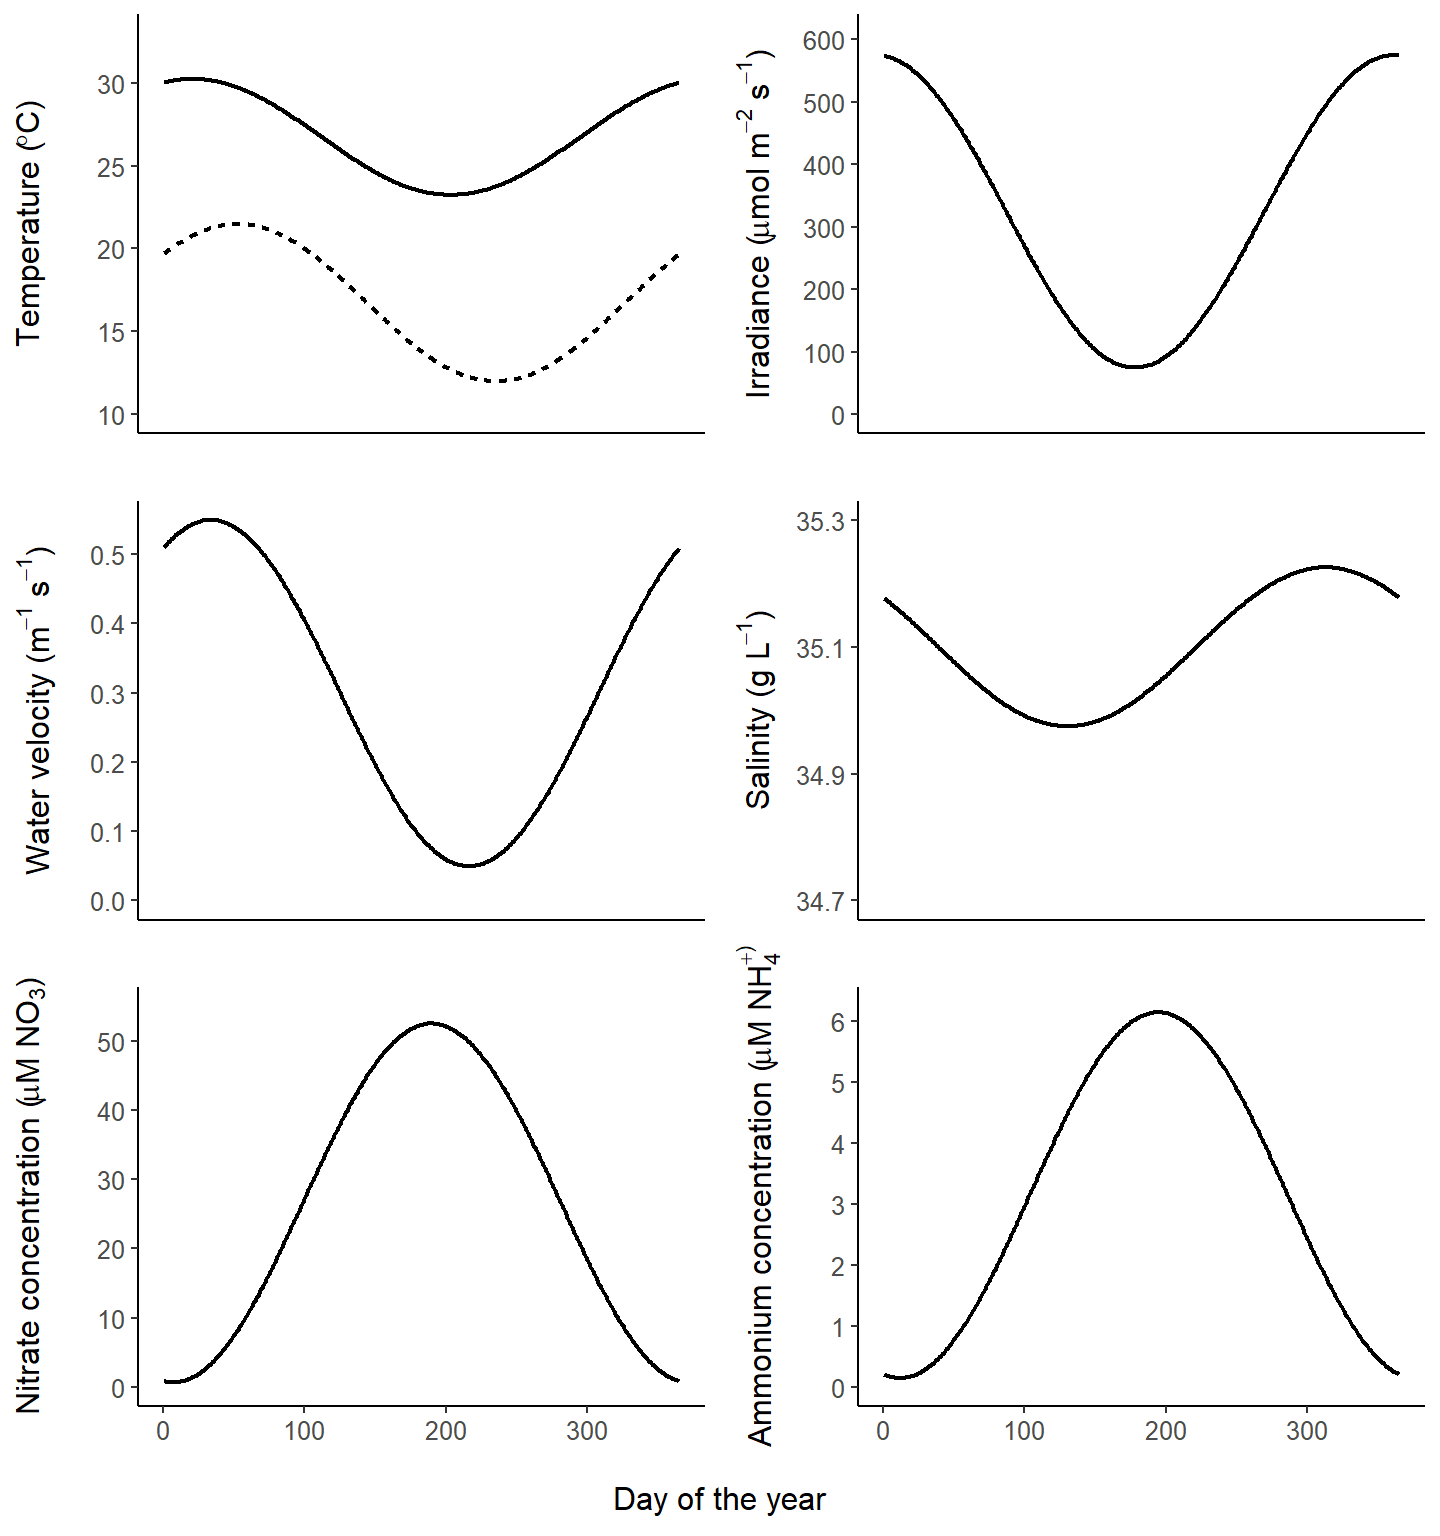

In [ ]:
library(cowplot)

p1 <- sens_cond %>% 
  dplyr::filter(t <= 365) %>% 
  ggplot(aes(x = t, y = T_input, linetype = as.factor(T_level))) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(10, 35, 5), limits = c(10, 33)) +
  labs(y = expression("Temperature ("*degree*"C)")) +
  prettyplot + 
  annotate("text", x = -Inf, y = Inf, label = "A", hjust = 1.2, vjust = 1, size = 4, fontface = "plain") +
  theme(legend.position = "none", axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())

p2 <- sens_cond %>% 
  dplyr::filter(t <= 365 & T_level == 1) %>% 
  ggplot(aes(x = t, y = I_input)) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(0, 700, 100), limits = c(0, 610)) +
  labs(y = expression("Irradiance ("*mu*"mol m"^-2*" s"^-1*")")) +
  prettyplot + 
  annotate("text", x = -Inf, y = Inf, label = "B", hjust = 1.2, vjust = 1, size = 4, fontface = "plain") +
  theme(legend.position = "none", axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())

p3 <- sens_cond %>% 
  dplyr::filter(t <= 365 & T_level == 1) %>% 
  ggplot(aes(x = t, y = U_input)) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(0, 0.6, 0.1), limits = c(0, 0.55)) +
  labs(y = expression("Water velocity (m"^-1*" s"^-1*")")) +
  prettyplot + 
  annotate("text", x = -Inf, y = Inf, label = "C", hjust = 1.2, vjust = 1, size = 4, fontface = "plain") +
  theme(legend.position = "none", axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())

p4 <- sens_cond %>% 
  dplyr::filter(t <= 365 & T_level == 1) %>% 
  ggplot(aes(x = t, y = S_input)) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(34.5, 36.5, 0.2), limits = c(34.7, 35.3)) +
  labs(y = expression("Salinity (g L"^-1*")")) +
  prettyplot + 
  annotate("text", x = -Inf, y = Inf, label = "D", hjust = 1.2, vjust = 1, size = 4, fontface = "plain") +
  theme(legend.position = "none", axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())

p5 <- sens_cond %>% 
  dplyr::filter(t <= 365 & T_level == 1) %>% 
  ggplot(aes(x = t, y = Ni_input)) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(0, 60, 10), limits = c(0, 55)) +
  labs(y = nitrate_lab) +
  prettyplot + 
  annotate("text", x = -Inf, y = Inf, label = "E", hjust = 1.2, vjust = 1, size = 4, fontface = "plain") +
  theme(legend.position = "none", axis.title.x = element_blank())

p6 <- sens_cond %>% 
  dplyr::filter(t <= 365 & T_level == 1) %>% 
  ggplot(aes(x = t, y = Am_input)) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(0, 10, 1), limits = c(0, 6.25)) +
  labs(y = ammonium_lab) +
  prettyplot + 
  annotate("text", x = -Inf, y = Inf, label = "F", hjust = 1.2, vjust = 1, size = 4, fontface = "plain") +
  theme(legend.position = "none", axis.title.x = element_blank())

plot_grid(
  plot_grid(p1, p2, p3, p4, p5, p6, ncol = 2, align = "hv"),
  ggdraw() + draw_label("Day of the year", size = 12),
  ncol = 1,
  rel_heights = c(0.95, 0.05)  # Adjust these values to control spacing
)

## Growth and bioremediation

### Growth limitations

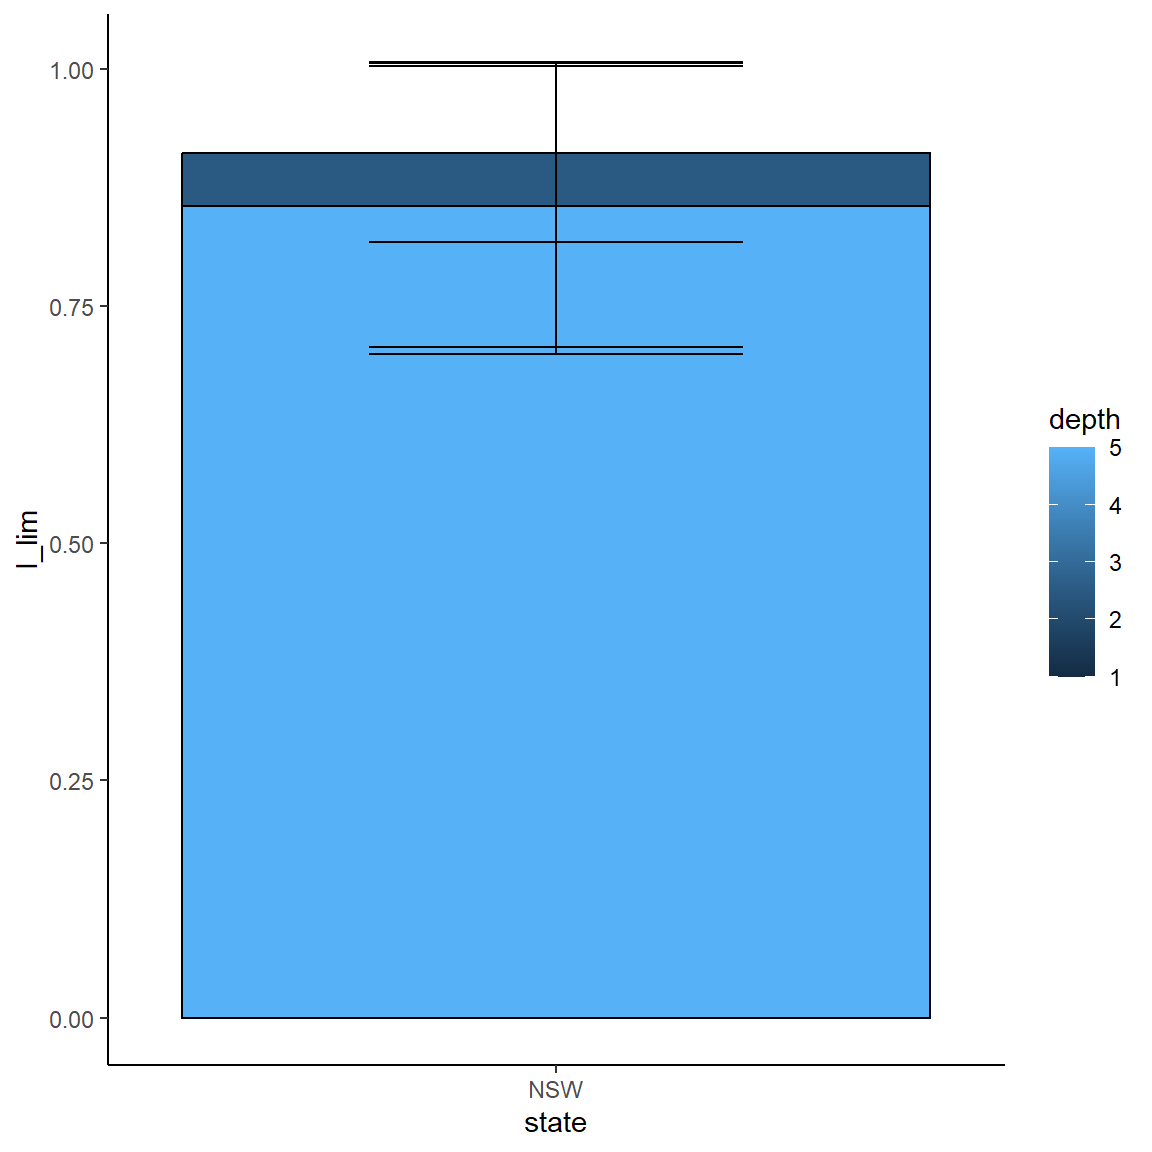

In [ ]:
d_top_PL <- tar_read(d_top_PL, store = cell_store)

Ilim_cell <- list(
  # file.path(cell_data, "Ilim_cell_PL_NTE.parquet") %>% arrow::read_parquet(),
  # file.path(cell_data, "Ilim_cell_PL_TAS.parquet") %>% arrow::read_parquet(),
  # file.path(cell_data, "Ilim_cell_PL_VIC.parquet") %>% arrow::read_parquet(),
  # file.path(cell_data, "Ilim_cell_PL_QLD.parquet") %>% arrow::read_parquet(),
  # file.path(cell_data, "Ilim_cell_PL_SAU.parquet") %>% arrow::read_parquet(),
  # file.path(cell_data, "Ilim_cell_PL_WAS.parquet") %>% arrow::read_parquet(),
  # file.path(cell_data, "Ilim_cell_PL_WAN.parquet") %>% arrow::read_parquet(),
  file.path(cell_data, "Ilim_cell_PL_NSW.parquet") %>% arrow::read_parquet()
) %>% 
  bind_rows() %>% 
  dplyr::select(-t)

# Ilim_means <- Ilim_cell %>% 
#   group_by(state, depth, yday) %>% 
#   reframe(I_lim = mean(I_lim, na.rm = T))
# 
# ggplot(Ilim_means, aes(x = yday, y = I_lim, colour = depth)) +
#   geom_line(linewidth = 0.75) +
#   facet_wrap(facets = vars(state)) +
#   theme_classic()

Ilim_means <- Ilim_cell %>% 
  group_by(state, depth) %>% 
  reframe(I_sd = sd(I_lim, na.rm = T),
          I_lim = mean(I_lim, na.rm = T))

ggplot(Ilim_means, aes(x = state, y = I_lim, fill = depth, ymin = I_lim-I_sd, ymax = I_lim+I_sd)) +
  geom_col(colour = "black", position = position_dodge(), width = 1) +
  geom_errorbar(position = position_dodge(width = 1), width = 0.5) +
  theme_classic()

In [ ]:
Ilim_cell <- Ilim_cell %>% 
  dplyr::filter(depth == "2.5") %>% 
  dplyr::select(-c(irradiance, depth, state)) %>% 
  merge(cell_coords, by = "cell_no")

# var_rast <- terra::rast(list(x = Ilim_cell$longitude, y = Ilim_cell$latitude, z = Ilim_cell$I_lim))
# crs(var_rast) <- "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"))

### Total growth and bioremediation

# Results

## Species parameterisation

In [ ]:
N_uptake <- file.path(spec_data, "N_uptake.parquet") %>% 
  read_parquet()

ggplot(N_uptake, aes(x = uM, y = uptake_uM, linetype = form)) +
  geom_line(linewidth = 0.75) +
  labs(x = expression("Ambient concentration ("*mu*"M)"), y = expression("Uptake rate ("*mu*"mol gDW"^-1*"d"^-1*")")) +
  scale_y_continuous(breaks = seq(0, 3.5, 0.05), limits = c(0, 0.30)) +
  scale_x_continuous(breaks = seq(0, 30, 5), limits = c(0,25)) +
  prettyplot + 
  theme(legend.position = "none",
        aspect.ratio = 0.65,
        text = element_text(family = "sans", size = 10, colour = "black"))

In [ ]:
T_response <- file.path(spec_data, "T_response.parquet") %>% 
  read_parquet() %>% 
  mutate(species = factor(species, levels = c("taxi", "arma")))

ggplot(T_response, aes(x = temp, y = Tlim, colour = species)) +
  geom_line(linewidth = 0.75) +
  labs(x = expression("Temperature ("*degree*"C)"), y = "Relative growth") +
  scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(0,1)) +
  scale_x_continuous(breaks = seq(0, 40, 5), limits = c(0,35)) +
  prettyplot + 
  theme(
    legend.position = "none",
    legend.title = element_blank(),
    aspect.ratio = 0.65,
    text = element_text(family = "sans", size = 10, colour = "black")
    )

In [ ]:
I_response <- file.path(spec_data, "I_response.parquet") %>% 
  read_parquet() %>% 
  mutate(depth_m = as.factor(depth_m))

ggplot(I_response, aes(x = light, y = Ilim, linetype = as.factor(depth_m))) +
  geom_line(linewidth = 0.75) +
  facet_wrap(facets = vars(species)) +
  labs(x = expression("Surface light (PPFD)"), y = "Relative growth") +
  scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(0,1)) +
  scale_linetype_manual(values = c("solid", "dashed", "dotdash", "dotted")) +
  prettyplot + 
  theme(
    legend.position = "none",
    aspect.ratio = 0.65,
    text = element_text(family = "sans", size = 10, colour = "black"),
    strip.text = element_blank()
    )

In [ ]:
S_response <- file.path(spec_data, "S_response.parquet") %>% 
  read_parquet()

ggplot(S_response, aes(x = sali, y = Slim)) +
  geom_line(linewidth = 0.75) +
  labs(x = expression("Salinity (g L"^-1*")"), y = "Relative growth") +
  scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(0,1)) +
  scale_x_continuous(breaks = seq(0, 60, 5), limits = c(19,45)) +
  prettyplot + 
  theme(
    legend.position = "none",
    aspect.ratio = 0.65,
    text = element_text(family = "sans", size = 10, colour = "black")
    )

(`geom_line()`).

(`geom_line()`).

set. Placing graphs unaligned.

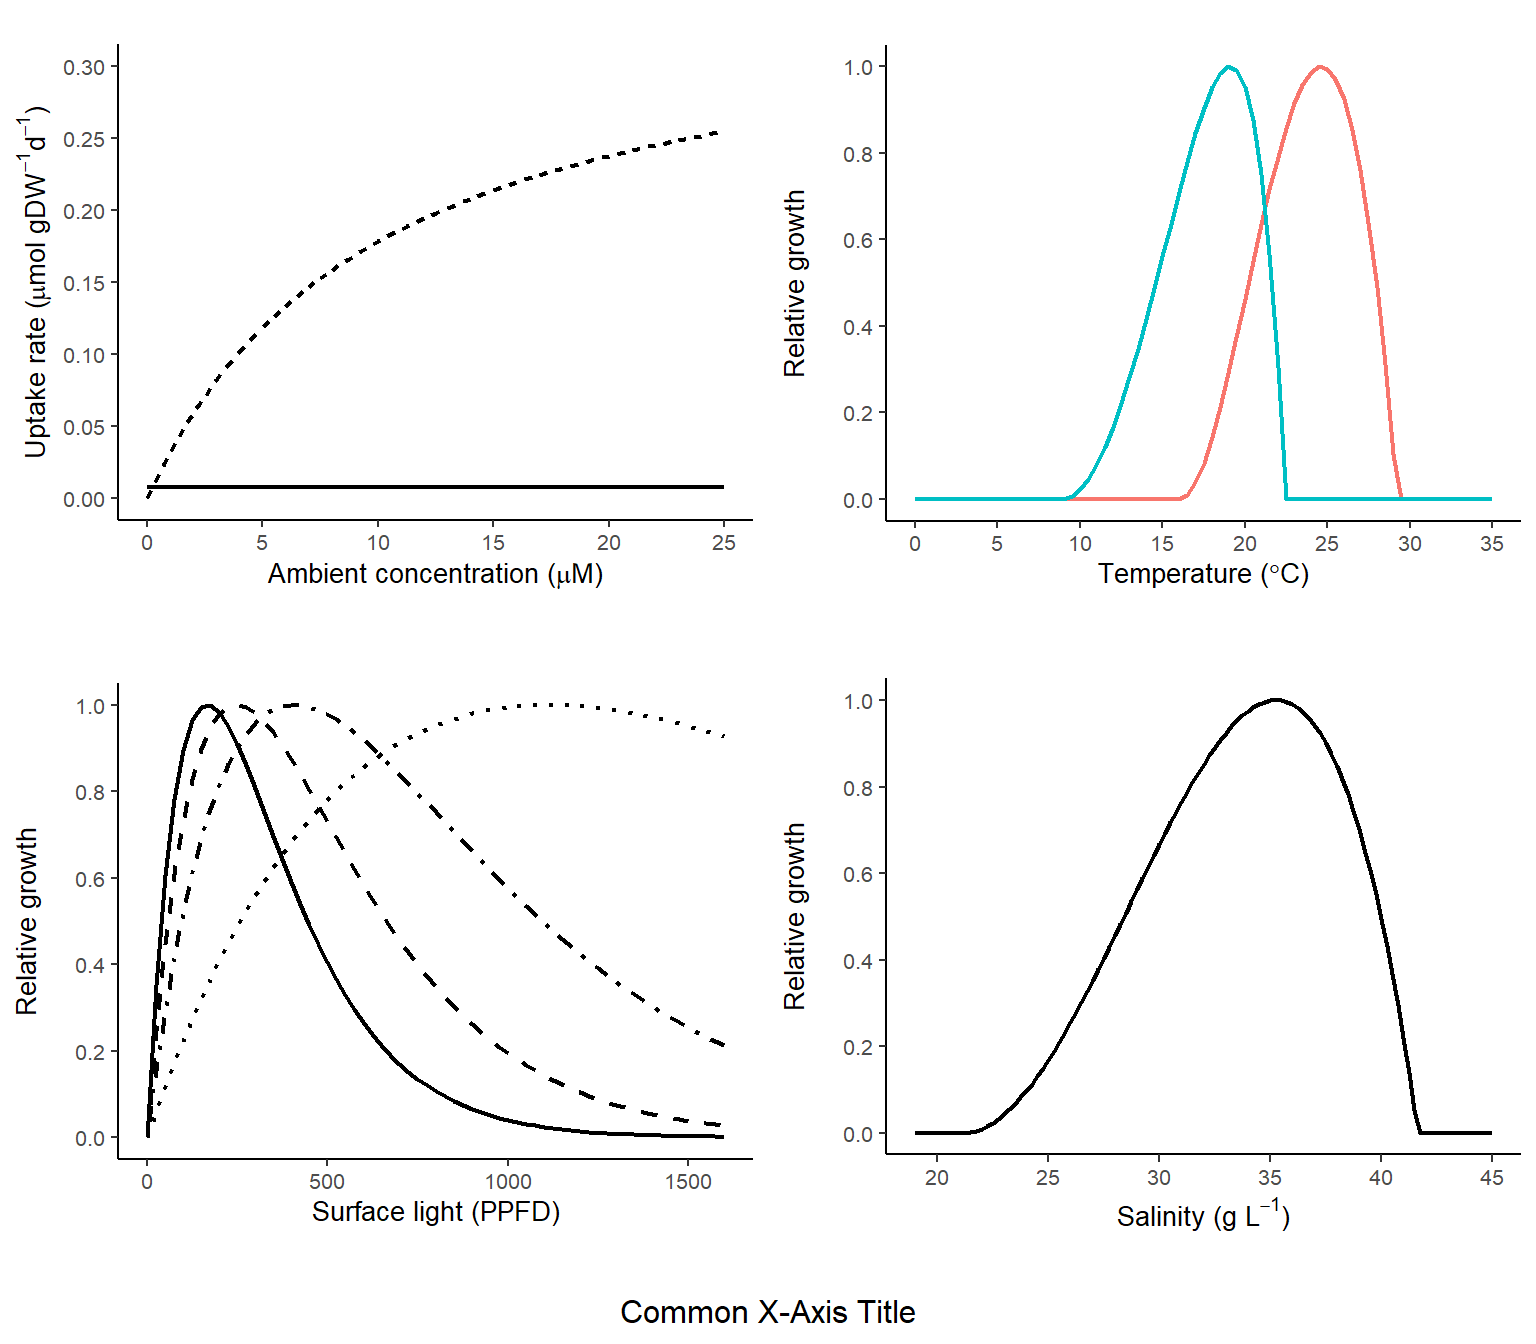

In [ ]:
library(gridExtra)
library(grid)

N_uptake <- file.path(spec_data, "N_uptake.parquet") %>% 
  read_parquet()
S_response <- file.path(spec_data, "S_response.parquet") %>% 
  read_parquet()
I_response <- file.path(spec_data, "I_response.parquet") %>% 
  read_parquet() %>% 
  mutate(depth_m = as.factor(depth_m))
T_response <- file.path(spec_data, "T_response.parquet") %>% 
  read_parquet() %>% 
  mutate(species = factor(species, levels = c("taxi", "arma")))

p1 <- ggplot(N_uptake, aes(x = uM, y = uptake_uM, linetype = form)) +
  geom_line(linewidth = 0.75) +
  labs(x = expression("Ambient concentration ("*mu*"M)"), y = expression("Uptake rate ("*mu*"mol gDW"^-1*"d"^-1*")")) +
  scale_y_continuous(breaks = seq(0, 3.5, 0.05), limits = c(0, 0.30)) +
  scale_x_continuous(breaks = seq(0, 30, 5), limits = c(0,25)) +
  prettyplot + 
  theme(legend.position = "none",
        aspect.ratio = 0.75,
        text = element_text(family = "sans", size = 10, colour = "black"))

p2 <- ggplot(T_response, aes(x = temp, y = Tlim, colour = species)) +
  geom_line(linewidth = 0.75) +
  labs(x = expression("Temperature ("*degree*"C)"), y = "Relative growth") +
  scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(0,1)) +
  scale_x_continuous(breaks = seq(0, 40, 5), limits = c(0,35)) +
  prettyplot + 
  theme(legend.position = "none",
        legend.title = element_blank(),
        aspect.ratio = 0.75,
        text = element_text(family = "sans", size = 10, colour = "black"))

p3 <- ggplot(I_response, aes(x = light, y = Ilim, linetype = as.factor(depth_m))) +
  geom_line(linewidth = 0.75) +
  facet_wrap(facets = vars(species)) +
  labs(x = expression("Surface light (PPFD)"), y = "Relative growth") +
  scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(0,1)) +
  scale_linetype_manual(values = c("solid", "dashed", "dotdash", "dotted")) +
  prettyplot + 
  theme(legend.position = "none",
        aspect.ratio = 0.75,
        text = element_text(family = "sans", size = 10, colour = "black"),
        strip.text = element_blank())

p4 <- ggplot(S_response, aes(x = sali, y = Slim)) +
  geom_line(linewidth = 0.75) +
  labs(x = expression("Salinity (g L"^-1*")"), y = "Relative growth") +
  scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(0,1)) +
  scale_x_continuous(breaks = seq(0, 60, 5), limits = c(19,45)) +
  prettyplot + 
  theme(legend.position = "none",
        aspect.ratio = 0.75,
        text = element_text(family = "sans", size = 10, colour = "black"))

p1 <- p1 + annotate("text", x = -Inf, y = Inf, label = "A", hjust = 1.5, vjust = 1, size = 4)
p2 <- p2 + annotate("text", x = -Inf, y = Inf, label = "B", hjust = 1.5, vjust = 1, size = 4)
p3 <- p3 + annotate("text", x = -Inf, y = Inf, label = "C", hjust = 1.5, vjust = 1, size = 4)
p4 <- p4 + annotate("text", x = -Inf, y = Inf, label = "D", hjust = 1.5, vjust = 1, size = 4)

plot_grid(
  plot_grid(p1, p2, p3, p4, ncol = 2, align = "hv"),
  ggdraw() + draw_label("Common X-Axis Title", size = 12),
  ncol = 1,
  rel_heights = c(0.95, 0.05)  # Adjust these values to control spacing
)

### Parameter sensitivity

 [1] "V_am"  "K_am"  "C_ni"  "Q_min" "Q_max" "mu"    "D_ve"  "T_opt" "T_min"
[10] "T_max"

 [1] "M_ni"  "K_c"   "a_cs"  "S_opt" "S_min" "S_max" "h_a"   "h_b"   "h_c"  
[10] "h_max" "DWWW"  "I_o"  

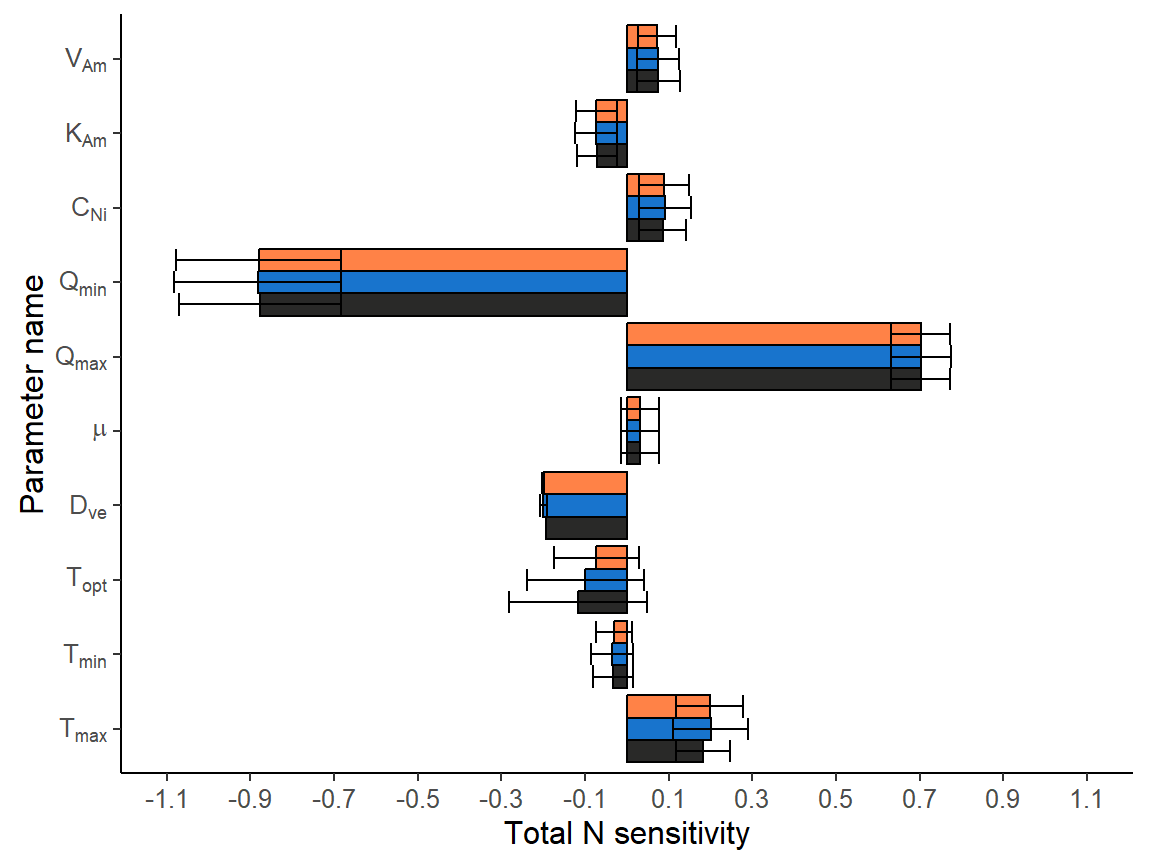

In [ ]:
sens_arma <- file.path(spec_data, "sensitivity_arma_calc_combTU.parquet") %>% 
  read_parquet() #%>% 
  # dplyr::filter(!param %in% c("M_am", "C_am", "M_ot", "C_ot"))
exlude <- unique(sens_arma$param[abs(sens_arma$sens) < 0.01]) %>% as.character
sens_arma <- sens_arma %>% 
  dplyr::filter(!param %in% c(exlude, "M_am", "C_am", "M_ot", "C_ot"))
sens_arma$param <- droplevels(sens_arma$param)

levels(sens_arma$param)

 [1] "V_am"  "K_am"  "C_ni"  "Q_min" "Q_max" "K_c"   "mu"    "D_ve"  "T_opt"
[10] "T_min" "T_max"

 [1] NA      "M_ni"  "a_cs"  "S_opt" "S_min" "S_max" "h_a"   "h_b"   "h_c"  
[10] "h_max" "DWWW"  "I_o"  

(`geom_col()`).

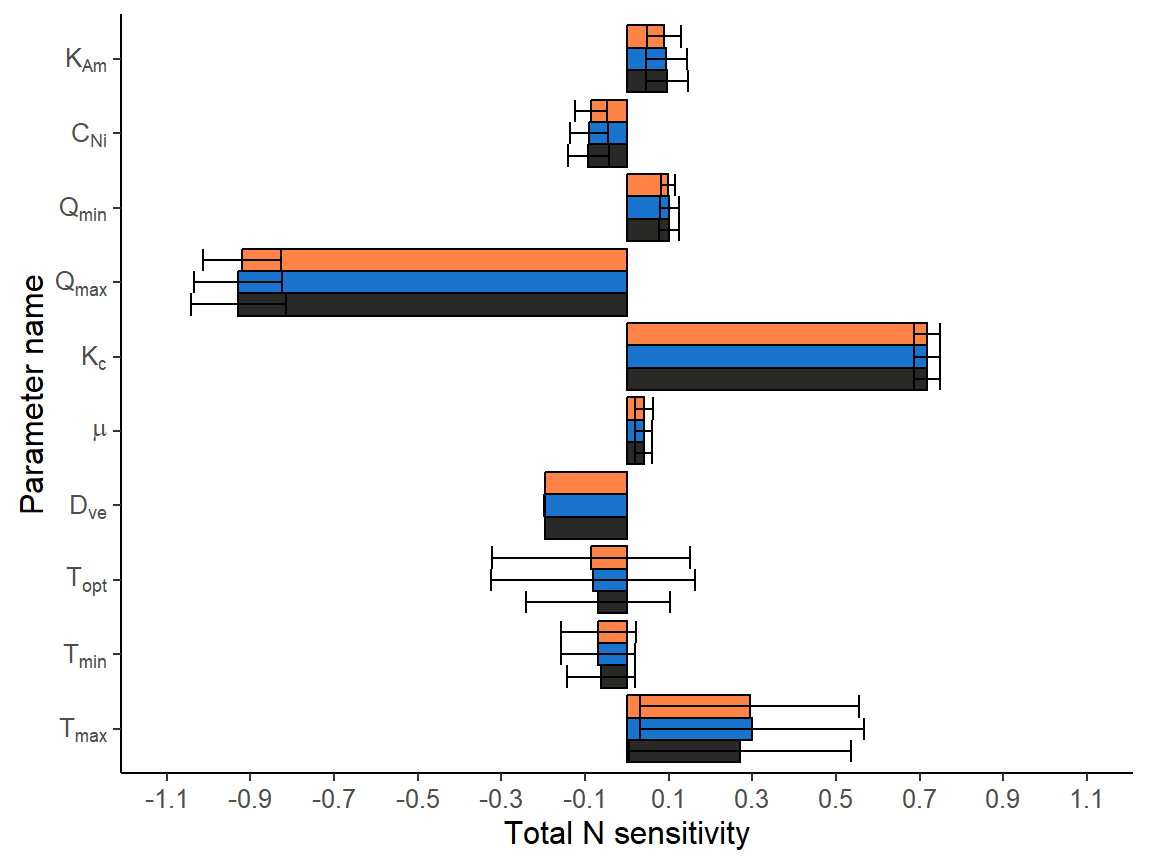

In [ ]:
sens_taxi <- file.path(spec_data, "sensitivity_taxi_calc_combTU.parquet") %>% 
  read_parquet()
exlude <- unique(sens_taxi$param[abs(sens_taxi$sens) < 0.01]) %>% as.character
sens_taxi <- sens_taxi %>% 
  dplyr::filter(!param %in% c(exlude, "M_am", "C_am", "M_ot", "C_ot"))
sens_taxi$param <- droplevels(sens_taxi$param)

levels(sens_taxi$param)

## Growth and bioremediation

### Temperature limitation

In [ ]:
Tlim_cell <- list(
  # file.path(runs_data, "Ilim_cell_PL_NTE.parquet") %>% arrow::read_parquet(),
  # file.path(runs_data, "Ilim_cell_PL_TAS.parquet") %>% arrow::read_parquet(),
  # file.path(runs_data, "Ilim_cell_PL_VIC.parquet") %>% arrow::read_parquet(),
  # file.path(runs_data, "Ilim_cell_PL_QLD.parquet") %>% arrow::read_parquet(),
  # file.path(runs_data, "Ilim_cell_PL_SAU.parquet") %>% arrow::read_parquet(),
  # file.path(runs_data, "Ilim_cell_PL_WAS.parquet") %>% arrow::read_parquet(),
  # file.path(runs_data, "Ilim_cell_PL_WAN.parquet") %>% arrow::read_parquet(),
  file.path(runs_data, "Tlim_cell_PL_NSW.parquet") %>% arrow::read_parquet()
) %>% 
  bind_rows() %>% 
  merge(cell_coords, by = c("state", "cell_no")) %>% 
  mutate(consec_0.75 = NA,
         consec_0.50 = NA)

By contrast, South Australia and southern Western Australia showed weak seasonal variation in temperature limitation but much higher spatial variation. The only area that appeared to have ideal temperature conditions for *A. armata* growth year-round was the area between Esperance and Albany in southern Western Australia (Figure 20).

Figure 20: The maximum number of days where Tlim $\geq$ 0.75 for *A. armata* in a typical year.

Figure 21: Limitation of relative growth by temperature for *A. armata* across all cells in a typical year (mean $\pm$ SD).

Within the model, the only difference between the two *Asparagopsis* species was their temperature response. Despite its higher temperature tolerance (see Figure 16) *A. taxiformis* seemed overall more limited by temperature than *A. armata* across Australia (Figure 23). The tropical species was mostly unable to grow below 33˚S on the west coast and 35˚S, and there was only a very small area off the central coast of Western Australia just outside of Shark Bay where temperature conditions were ideal for *A. taxiformis* year-round.

Figure 22: The maximum number of days where Tlim $\geq$ 0.75 for *A. taxiformis* in a typical year.

Figure 23: Limitation of relative growth by temperature for *A. taxiformis* across all cells in a typical year (mean $\pm$ SD).

### Light limitation

In [ ]:
Ilim_cell <- list(
  file.path(runs_data, "Ilim_cell_PL_NTE.parquet") %>% arrow::read_parquet(),
  file.path(runs_data, "Ilim_cell_PL_TAS.parquet") %>% arrow::read_parquet(),
  file.path(runs_data, "Ilim_cell_PL_VIC.parquet") %>% arrow::read_parquet(),
  file.path(runs_data, "Ilim_cell_PL_QLD.parquet") %>% arrow::read_parquet(),
  file.path(runs_data, "Ilim_cell_PL_SAU.parquet") %>% arrow::read_parquet(),
  file.path(runs_data, "Ilim_cell_PL_WAS.parquet") %>% arrow::read_parquet(),
  file.path(runs_data, "Ilim_cell_PL_WAN.parquet") %>% arrow::read_parquet(),
  file.path(runs_data, "Ilim_cell_PL_NSW.parquet") %>% arrow::read_parquet()
) %>% 
  bind_rows()

Figure 28: The maximum number of days where Ilim $\geq$ 0.75 for *Asparagopsis* spp. in a typical year.

Figure 29: Limitation of relative growth by changes in seasonal light availability for *Asparagopsis* spp. across all cells grown at 0.5 m depth in a typical year (mean $\pm$ SD).

### Total growth and bioremediation

After running the model in all cells, there were 1034 cells (of 11677) where the run failed due to missing environmental data or the cell being too shallow to accommodate the 5.5 m canopy. Overall, nitrogen removal by *A. armata* and *A. taxiformis* was less than other species.

Nitrogen removal by *A. armata* was fairly consistent across a typical year in Tasmania with a mean of 204.0 g m-2 of farmed area, Victoria with a mean of 256.0 g m-2 of farmed area, and South Australia with a mean of 327.0 g m-2 of farmed area (Figure 34). The highest total removal across the year was also in South Australia. Nitrogen removal was most temporally variable in New South Wales, ranging from 8.5 g m-2 of farmed area to 540.0 g m-2 of farmed area, peaking when the simulated macroalgae was out-planted in August.

Figure 34: Total nitrogen removed (mean $\pm$ SD) by *A. armata* planted in different months across all cell in each state.

Nitrogen removal in South Australia was relatively spatially consistent, while the east coast of Australia showed greater variability (Figure 35). Some areas of Victoria on the borders of New South Wales and South Australia showed nitrogen removal comparable to the neighbouring state, likely reflecting the influence of data from the different reference stations. The potential “hotspot” area between Esperance and Albany in southern Western Australia, identified in temperature limitation maps above (see Figure 20), did not show higher nitrogen removal rates than the rest of the state. Similarly, Tasmania showed moderate nitrogen removal rates year-round (), despite the species being relatively limited by temperature from May to November (see Figure 21).

Figure 35: Southern half of Australia showing the total nitrogen removed by *A. armata* planted in March (top) or August (bottom).

Nitrogen removal by *A. taxiformis* was highest in New South Wales, with a mean nitrogen removal rate of 304 g m-2 of farmed area in each month of outplanting (Figure 36). Nitrogen removal was less consistent across the year in South Australia (peaking at a mean of 158 g m-2 of farmed area in February), northern Western Australia (peaking at 143 g m-2 of farm in June) and the Northern Territory (peaking at 142 g m-2 of farmed area in June).

Figure 36: Total nitrogen removed (mean $\pm$ SD) by *A. taxiformis* planted in different months across all cell in each state.

Total nitrogen removal by *A. taxiformis* was relatively spatially consistent in most states except for Queensland, where the southern coast showed higher removal rates (Figure 37). This was likely driven by ambient nitrogen data, particularly the differences between reference stations (Figures 8 and 9). By contrast, the spatial variability seen in the north-west of the country (Figure 37) is more likely driven by temperature and light variability, given that there are fewer reference stations and outfall points (Figure 6).

Figure 37: Total nitrogen removed by *A. taxiformis* planted in May in the Northern Territory and northern Western Australia (top), and in October in New South Wales and Queensland (bottom).

## Growth scenarios

When compared with the base scenario, all species were able to remove the most nitrogen in the fish farm scenario, almost certainly because of the increase in ammonium concentration from (very low) background levels (Figure 42). *Asparagopsis armata* and *A. taxiformis* consistently removed more nitrogen in the fish farm scenario.

Differences in nitrogen removed by *Asparagopsis* were minimal in the estuary mouth scenario across all states (ranging from -2.1% to +2.5% of base). Similarly, in the shallow bay scenario, *Asparagopsis* was able to remove from 0.4 to 9.5$\times$ more nitrogen. The deep water scenario showed mostly negative but relatively small changes from the base removal, with changes ranging from -36% removal by *A. taxiformis* in New South Wales to +16.2% removed by *A. armata* in northern Western Australia.

Figure 42: Nitrogen removal for different scenarios compared to the base scenario. Colours show the different scenarios as fish farm (purple), deep water (green), estuary mouth (orange) and shallow bay (pink).

# Discussion

This study demonstrates that seaweed aquaculture has significant bioremediation potential across Australia, with scenario modelling suggesting that *Asparagopsis* species can be effective at removing excess nitrogen from the environment. Across a range of conditions, these species showed nitrogen uptake potential that varied by region and season. Our model tested different pollution contexts, including marine aquaculture waste and estuarine runoff, highlighting the ability of seaweed cultivation to mitigate nutrient pollution.

Our analysis highlighted variability in bioremediation potential among different macroalgae species under varying environmental conditions across Australia. The local availability of nitrogen, specifically ammonium and nitrate, emerged as the primary driver of this variability. Nitrate, generally in very low concentrations, is the predominant form of nitrogen in Australian coastal waters, which can be considered as oligotrophic (e.g. Chen et al., 2020; Pritchard et al., 2001; Twomey et al., 2007; Wild-Allen et al., 2010). This poses a clear challenge for the use of macroalgae for bioremediation in Australia. While all species studied showed higher uptake efficiency of ammonium, the low ambient levels of this compound limit their overall nitrogen uptake. Anthropogenic nutrient inputs, such as those from fish farms and sewage treatment outfalls, can create high nitrogen environments conducive to effective macroalgae cultivation and therefore bioremediation. The highest mean concentration of nitrate reported here from available data was 3.9 µM, and the fish farm scenario almost doubled this value (7.4 µM). While this is expected within Australian waters, it is still very low in a global context. For example, in Chile, mean coastal nitrate concentrations near salmon farms range from 3.2 µM in summer to 22.1 µM in winter (Varela et al., 2018).

All species studied here demonstrated a preference for ammonium uptake over nitrate, with *Asparagopsis armata* and *A. taxiformis* showing the highest uptake efficiency of ammonium. However, in the context of bioremediation, a species’ ability to take advantage of surges in nutrient concentrations is perhaps more important than its absolute uptake rate. By contrast, *Asparagopsis*, has a constant nitrate uptake rate which was minimally impacted by changes in nitrate concentrations. It is worth nothing that minimal seasonal variation in nutrient concentration was included in the present study. However, seasonal trends in ammonium and nitrate concentrations are often observed in coastal waters due to natural process (e.g. phytoplankton growth) and anthropogenic inputs (e.g. urban runoff from rainfall events).

Temperature played a secondary role in influencing nitrogen uptake efficiency, generally reflecting the natural geographic ranges of the species. *Asparagopsis armata* showed the potential for year-round growth (indicating year-round nitrogen uptake) in cooler regions of Australia, reflecting its temperate to subtropical range and wide temperature tolerance. *Asparagopsis taxiformis* showed more restricted temperature ranges, limiting their bioremediation potential to specific regions and seasons.

Light-related parameters did not appear to significantly influence the nitrogen uptake of any macroalgae species, possibly driven by the low resolution in the available light attenuation data. Given the similar light responses among species and the consistent surface irradiance among all regions, all species were only modelled as growing at a depth of 0.5 m and in uniformly clear water. This uniformity in light response and growth depth simplified the model, ensuring that light availability did not confound the results. There is, however, a clear need for accurate site-specific light attenuation data to assess the impact of depth on macroalgae growth, as light is crucial for photosynthesis and growth. Smart et al (2022) used a laboratory setting to examine the nitrogen uptake kinetics of four kelp species under different ammonium concentrations. The nitrogen uptake rate of all species varied seasonally, increasing with higher temperatures and light availability.

*Asparagopsis* species are currently the most commercially valuable for cultivation than the other species studied here due to their use in reducing methane emissions from livestock. However, modelling revealed that, despite the high nitrogen tissue content of *Asparagopsis* spp., these species are significantly less efficient in nitrogen uptake. This inefficiency is likely due to their lower rates of nitrate uptake compared to the other species combined with Australia’s low nitrate waters, their high nitrogen tissue requirements, and their more narrow temperature tolerance. These assumptions, however, are largely based on research conducted in regions outside Australia (e.g. Torres et al., 2021; Zanolla et al., 2019). More Australian local-scale studies are necessary to better understand the nitrogen uptake kinetics of *Asparagopsis* spp. in Australian coastal waters.

The study’s methodology, which integrated reference station and outfall data, provided a broad overview of spatial and temporal variation in nutrient concentrations in Australian coastal waters, However, the actual impact of outfalls and other nutrient sources on nitrogen concentration is more complex and site-specific, often stratified by depth and influenced by local hydrodynamic conditions (Pritchard et al., 2001). This suggests that detailed knowledge of ammonium and nitrate concentrations at specific sites, along with species-specific uptake kinetics, is crucial for accurately assessing the bioremediation potential of macroalgae in different coastal environments. Furthermore, individual site conditions could provide valuable insights for growers on the suitability of particular species for cultivation. For example, while the present model captured some thalli degradation due to high water velocities, it did not include breakage off the lines due to high swells or storm events, which would have a greater impact on more fragile seaweeds like *Asparagopsis* spp.

Given *Asparagopsis* is the only genus studied here that currently has significant commercial value, future research should focus on identifying ‘hotspots’, considering temperature thresholds, time of year and placement, where *Asparagopsis* can thrive. Additionally, understanding the nitrogen uptake rate of the *Asparagopsis* gametophyte life stage, rather than assuming it is identical to the tetrasporophyte life stage, is essential for advancing open-water *Asparagopsis* culture for bioremediation.

Overall, this study provides valuable insights into the bioremediation potential of native Australian macroalgae species, highlighting the importance of nitrogen availability and temperature in shaping their effectiveness. The findings highlight the need for species selection and consideration of site-specific conditions when integrating seaweed aquaculture for bioremediation in Australian waters. As the industry explores seaweed farming’s role in coastal management, future research should focus on refining spatial models, incorporating finer-scale environmental data, and evaluating economic feasibility. With the right approach, seaweed farming could reduce water pollution, support sustainable aquaculture, and enhance coastal ecosystem health. This study lays the groundwork for guiding site selection and key considerations in expanding seaweed farming across Australia.

# Acknowledgments

The project authors would like to thank Jens Knauer and Margie Rule of the for their input and expertise on \*Asparagopsis\*\* husbandry, and Professor Rocky de Nys for his feedback on study methodology. Data for this study were sourced from Australia’s , which is enabled by the . Data were also sourced from the . Work for is undertaken for the Marine and Coastal Hub, a collaborative partnership supported through funding from the Australian Government’s .

# References